# Tuning the Beast

### Review of LSTM Tuning Methods for Forecasting Time Series
***
**_Brian Griner_**

3.25.18 (**updated 6.5.18**)

**Central NJ Deep Learning Meetup** 

Tigerlabs, Princeton NJ

***

![](https://upload.wikimedia.org/wikipedia/commons/c/cb/St_George_and_Dragon_Philly.JPG)

Sculpture of St. George and the Dragon in Fairmount Park, Philadelphia. Sculptor unknown, date - before 1900
***
Long Short-Term Memory networks (LSTMs) are a special type of Recurrent Neural Network (RNN) specifically designed to capture long-term correlations in a sequence without producing the technical issues of vanishing or exploding gradients during training associated with RNNs. Other benefits of LSTMs for sequence prediction are:
1. Internal memory state that can learn the temporal structure of the inputs
2. Ability to learn multiple parallel input sequences separately
3. Does't require a fixed window for input/output sequences like a multilayer perceptron (MLP)
***
**What is an LSTM?**
An LSTM network consists of sequential **Memory Blocks** composed of three sets of **weights** and **gates**:

**Weights**
1. Input weights
2. Output weights
3. _Internal State_ (Cell state)

**Gates**
1. _Forget_ gate
2. Input gate
3. Output gate

The Memory Block of an LSTM learns the temporal structure of the inputs through its _gates_ that takes the output of the previous block and the inputs at time t-1 and uses gates to create the current state at time t as shown in the diagram below. 

![](https://cdn-images-1.medium.com/max/1600/1*laH0_xXEkFE0lKJu54gkFQ.png) 

In an LSTM, sequence learning is a process of deconstructing the cell state by:
1. _Forgetting_ parts of previous inputs and states
2. Updating the prior cell state to use as _inputs_ to create the current cell state
3. Generating the _output_ sequence and updating the current cell state

For a step by step description of how the LSTM Memory Blocks function see the blog post [Understanding LSTM and its diagrams](https://medium.com/mlreview/understanding-lstm-and-its-diagrams-37e2f46f1714)

To learn more about LSTMs, see the original paper [Hochreiter S, Schmidthuber J. LONG SHORT-TERM MEMORY. Neural Computation. 1997; 9(8):1735-1780.](http://www.bioinf.jku.at/publications/older/2604.pdf)
***
The special architecture of the LSTM designed to remember single events over a long, unknown time periods makes it an interesting choice for forecasting complex time series; however, extensive tuning is required to maximize the potential of this algorithm. This post reviews several approaches to tuning an LSTM to optimize it for forecasting time series data. In order to compare the effect of different tuning approaches, the same dataset on monthly retail sales of a fast moving consumer package good is used in all the examples. 

This post is an adaptation/aggregation of the many posts and books by Jason Brownlee on LSTMs and time series forecasting. I encourage anyone interested in a deep dive to work through his posts and book on LSTMs in the links below.

LSTM book: [Brownlee J. Long Short-Term Memory Networks With Python. Machine Learning Mastery. 2017](https://machinelearningmastery.com/lstms-with-python/)

LSTM Forecasting Post: [Brownlee J. Time Series Forecasting with the Long Short-Term Memory Network in Python. 2017 Apr 7.](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

# Dataset 1: 36 Month Shampoo Sales Data

The first time series examined is a univariate monthly sales data for shampoo provided by
[DataMarket: Time Series Data Library (citing: Makridakis, Wheelwright and Hyndman (1998))](https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-three-year-period#!ds=22r0&display=line).


Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: shampooSales, dtype: float64


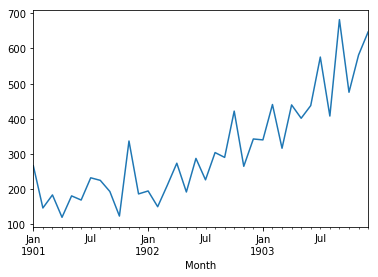

In [4]:
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
# load dataset
datafile = '~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv'
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
series = read_csv(datafile, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()

# Persistence _Single-Step_ Model Forecast - (yhat_t = y_t-1)
***
The naive model in time series analysis is the persistence forecast, i.e. prediction in the current time period is equal to the value of the series in the previous time period.

RMSE: 136.761


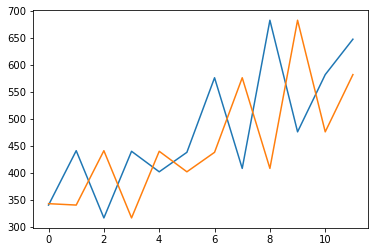

In [1]:
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
# load dataset
datafile = '~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv'
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
series = read_csv(datafile, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# split data into train and test
X = series.values
train, test = X[0:-12], X[-12:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # make prediction
    predictions.append(history[-1])
    # observation
    history.append(test[i])
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()

### RMSE: 136.761

The persistence forecast uses the naive modeling assumption that what happened before will happen again. This is shown clearly in the chart above by the orange line shifting the actual time trend forward one period.
***
# Prologue

To setup the use of LSTMs for time series forecasting, we will review the classic **Auto-Regressive-Integrated-Moving-Average (ARIMA)** as well as the **Multi-Layer Perceptron (MLP)** models as a background for time series modeling before we embark on the use and tuning of LSTMs for forecasting time series.

### Data Visualization

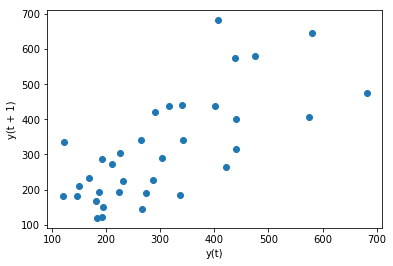

     t-1      t
0    NaN  266.0
1  266.0  145.9
2  145.9  183.1
3  183.1  119.3
4  119.3  180.3
          t-1         t
t-1  1.000000  0.719482
t    0.719482  1.000000


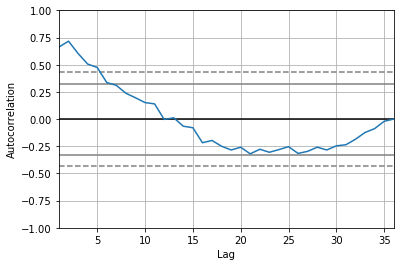

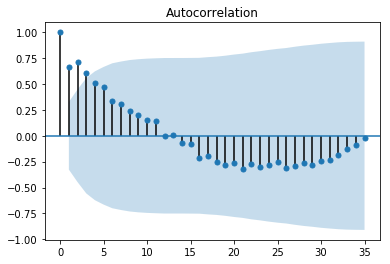

In [7]:
# check for AR1
from pandas.tools.plotting import lag_plot
lag_plot(series)
pyplot.show()

# create lagged inputs
from pandas import Series, DataFrame, concat
values = DataFrame(series.values)
df = concat([values.shift(1), values], axis=1)
df.columns = ['t-1', 't']
print(df.head())
auto_corr = df.corr()
print(auto_corr)

# autocorrelation plot
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(series)
pyplot.show()

# autocorrelation function
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series)
pyplot.show()


**Conclusion: Appears to be a strong and significant AR1 effect in the shampoo data**

## Classic Times Series ARIMA model

                             ARIMA Model Results                              
Dep. Variable:         D.shampooSales   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                       css-mle   S.D. of innovations             64.241
Date:                Wed, 30 May 2018   AIC                            406.340
Time:                        21:30:54   BIC                            417.227
Sample:                    02-01-1901   HQIC                           410.098
                         - 12-01-1903                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   12.0649      3.652      3.304      0.003       4.908      19.222
ar.L1.D.shampooSales    -1.1082      0.183     -6.063      0.000      -1.466      -0.750
ar.L2.D.sham

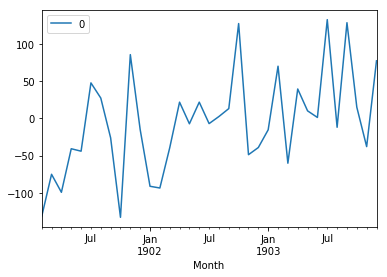

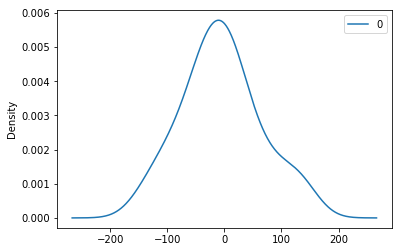

                0
count   35.000000
mean    -5.495192
std     68.132883
min   -133.296586
25%    -42.477853
50%     -7.186546
75%     24.748368
max    133.238005


In [9]:
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

# ARIMA model
from pandas import read_csv, datetime, DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

### Rolling Forecast ARIMA Model (one step at a time)

predicted=349.117703, expected=342.300000
predicted=306.513037, expected=339.700000
predicted=387.376420, expected=440.400000
predicted=348.154213, expected=315.900000
predicted=386.308773, expected=439.300000
predicted=356.082044, expected=401.300000
predicted=446.379447, expected=437.400000
predicted=394.737266, expected=575.500000
predicted=434.915586, expected=407.600000
predicted=507.923424, expected=682.000000
predicted=435.482891, expected=475.300000
predicted=652.743808, expected=581.300000
predicted=546.343507, expected=646.900000
Test RMSE: 83.417


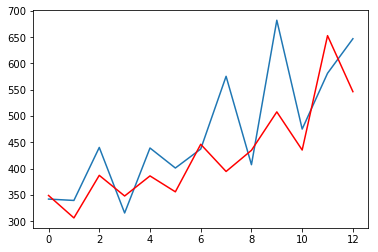

In [1]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

### Tuning: Grid Search ARIMA Model Hyperparameters

In [3]:
import warnings
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = sqrt(mean_squared_error(test, predictions))
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# load dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=228.966
ARIMA(0, 0, 1) MSE=195.308
ARIMA(0, 0, 2) MSE=154.886
ARIMA(0, 1, 0) MSE=134.176
ARIMA(0, 1, 1) MSE=97.767
ARIMA(0, 2, 0) MSE=259.499
ARIMA(0, 2, 1) MSE=135.360
ARIMA(1, 0, 0) MSE=152.029
ARIMA(1, 1, 0) MSE=84.388
ARIMA(1, 1, 1) MSE=83.688
ARIMA(1, 2, 0) MSE=136.411
ARIMA(2, 1, 0) MSE=75.432
ARIMA(2, 1, 1) MSE=88.089
ARIMA(2, 2, 0) MSE=99.302
ARIMA(4, 1, 0) MSE=81.545
ARIMA(4, 1, 1) MSE=82.440
ARIMA(4, 2, 0) MSE=87.157
ARIMA(4, 2, 1) MSE=68.519
ARIMA(6, 1, 0) MSE=82.523
ARIMA(6, 2, 0) MSE=79.128
ARIMA(8, 1, 0) MSE=80.522
Best ARIMA(4, 2, 1) MSE=68.519


predicted=399.145086, expected=342.300000
predicted=354.296662, expected=339.700000
predicted=429.967823, expected=440.400000
predicted=392.634658, expected=315.900000
predicted=420.191766, expected=439.300000
predicted=397.585275, expected=401.300000
predicted=487.892591, expected=437.400000
predicted=434.160086, expected=575.500000
predicted=467.057649, expected=407.600000
predicted=568.082731, expected=682.000000
predicted=468.024270, expected=475.300000
predicted=687.491668, expected=581.300000
predicted=617.839102, expected=646.900000
Test RMSE: 68.519


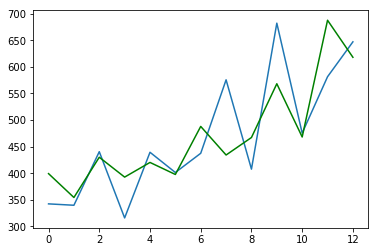

In [2]:
# New forecast using optimized ARIMA model hyperparameters (4,2,1)

from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(4,2,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='green')
pyplot.show()

**Conclusion: Optimizing ARIMA model hyperparameters reduced the RMSE by 22% to 69**

## Multilayer Percepton for Time Series Forecasting
***
### Tuning: Vary Training Epochs

1) Test RMSE: 116.420
2) Test RMSE: 116.474
3) Test RMSE: 95.267
4) Test RMSE: 147.988
5) Test RMSE: 111.981
6) Test RMSE: 107.390
7) Test RMSE: 125.961
8) Test RMSE: 97.276
9) Test RMSE: 210.763
10) Test RMSE: 94.550
11) Test RMSE: 135.252
12) Test RMSE: 108.999
13) Test RMSE: 109.253
14) Test RMSE: 115.118
15) Test RMSE: 187.871
16) Test RMSE: 103.561
17) Test RMSE: 138.030
18) Test RMSE: 107.083
19) Test RMSE: 211.572
20) Test RMSE: 124.217
21) Test RMSE: 143.996
22) Test RMSE: 126.078
23) Test RMSE: 95.203
24) Test RMSE: 138.741
25) Test RMSE: 135.234
26) Test RMSE: 113.059
27) Test RMSE: 188.081
28) Test RMSE: 133.109
29) Test RMSE: 110.657
30) Test RMSE: 139.264
1) Test RMSE: 146.016
2) Test RMSE: 106.090
3) Test RMSE: 135.492
4) Test RMSE: 106.142
5) Test RMSE: 106.436
6) Test RMSE: 94.005
7) Test RMSE: 96.041
8) Test RMSE: 106.814
9) Test RMSE: 95.707
10) Test RMSE: 107.020
11) Test RMSE: 105.331
12) Test RMSE: 104.902
13) Test RMSE: 135.224
14) Test RMSE: 135.825
15) Test RMSE

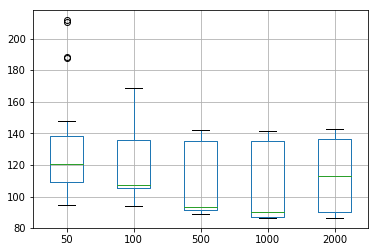

In [6]:
# Experiment - vary number of epochs

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an MLP network to training data
def fit_model(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=X.shape[1]))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
    return model

# run a repeated experiment
def experiment(repeats, series, epochs, lag, neurons):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, lag)
    supervised_values = supervised.values[lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the model
        batch_size = 4
        train_trimmed = train_scaled[2:, :]
        model = fit_model(train_trimmed, batch_size, epochs, neurons)
        # forecast test dataset
        test_reshaped = test_scaled[:,0:-1]
        output = model.predict(test_reshaped, batch_size=batch_size)
        predictions = list()
        for i in range(len(output)):
            yhat = output[i,0]
            X = test_scaled[i, 0:-1]
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

# load dataset
series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# experiment
repeats = 30
results = DataFrame()
lag = 1
neurons = 1
# vary training epochs
epochs = [50, 100, 500, 1000, 2000]
for e in epochs:
    results[str(e)] = experiment(repeats, series, e, lag, neurons)
# summarize results
print(results.describe())
# save boxplot
results.boxplot()
pyplot.savefig('boxplot_epochs.png')

**Conclusion: RMSE is minimized at 1,000 epochs with a min of 86.5, a median RMSE of 90 and mean of 105**

0) TrainRMSE=64.607118, TestRMSE=92.361790
1) TrainRMSE=67.848151, TestRMSE=86.528408
2) TrainRMSE=64.607667, TestRMSE=92.365602
3) TrainRMSE=61.750174, TestRMSE=89.020683
4) TrainRMSE=91.943364, TestRMSE=136.098753
5) TrainRMSE=67.850764, TestRMSE=86.398336
6) TrainRMSE=67.901898, TestRMSE=86.921872
7) TrainRMSE=64.607117, TestRMSE=92.362596
8) TrainRMSE=91.943365, TestRMSE=135.397369
9) TrainRMSE=67.853086, TestRMSE=86.711470


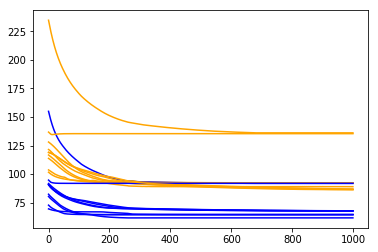

In [8]:
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

# Diagnostics - vary number of epochs

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df = df.drop(0)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
    # separate
    X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
    # forecast dataset
    output = model.predict(X, batch_size=batch_size)
    # invert data transforms on forecast
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        # invert scaling
        yhat = invert_scale(scaler, X[i], yhat)
        # invert differencing
        yhat = yhat + raw_data[i]
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
    return rmse

# fit an MLP network to training data
def fit(train, test, raw, scaler, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    # prepare model
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=X.shape[1]))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit model
    train_rmse, test_rmse = list(), list()
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        # evaluate model on train data
        raw_train = raw[-(len(train)+len(test)+1):-len(test)]
        train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
        # evaluate model on test data
        raw_test = raw[-(len(test)+1):]
        test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
    history = DataFrame()
    history['train'], history['test'] = train_rmse, test_rmse
    return history

# run diagnostic experiments
def run():
    # config
    repeats = 10
    n_batch = 4
    n_epochs = 1000
    n_neurons = 1
    n_lag = 1
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    # run diagnostic tests
    for i in range(repeats):
        history = fit(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
        pyplot.plot(history['train'], color='blue')
        pyplot.plot(history['test'], color='orange')
        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
    pyplot.savefig('diagnostic_epochs.png')

# entry point
run()

### Tuning: Varying the Number of Nodes in the Hidden Layer

1) Test RMSE: 92.586
2) Test RMSE: 138.579
3) Test RMSE: 91.071
4) Test RMSE: 135.671
5) Test RMSE: 90.088
6) Test RMSE: 135.976
7) Test RMSE: 92.587
8) Test RMSE: 90.284
9) Test RMSE: 135.676
10) Test RMSE: 92.583
11) Test RMSE: 91.297
12) Test RMSE: 138.376
13) Test RMSE: 92.572
14) Test RMSE: 92.586
15) Test RMSE: 137.139
16) Test RMSE: 92.260
17) Test RMSE: 92.601
18) Test RMSE: 91.026
19) Test RMSE: 135.977
20) Test RMSE: 137.106
21) Test RMSE: 135.895
22) Test RMSE: 91.910
23) Test RMSE: 141.739
24) Test RMSE: 92.599
25) Test RMSE: 136.741
26) Test RMSE: 92.569
27) Test RMSE: 92.608
28) Test RMSE: 91.649
29) Test RMSE: 92.617
30) Test RMSE: 92.588
1) Test RMSE: 114.511
2) Test RMSE: 83.832
3) Test RMSE: 103.272
4) Test RMSE: 97.226
5) Test RMSE: 137.552
6) Test RMSE: 84.528
7) Test RMSE: 94.134
8) Test RMSE: 126.662
9) Test RMSE: 100.458
10) Test RMSE: 97.353
11) Test RMSE: 83.371
12) Test RMSE: 99.422
13) Test RMSE: 96.972
14) Test RMSE: 97.574
15) Test RMSE: 84.121
16) Test RMS

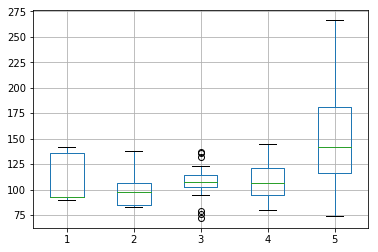

In [3]:
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

# Experiment - vary number of lagged inputs

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an MLP network to training data
def fit_model(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=X.shape[1]))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
    return model

# run a repeated experiment
def experiment(repeats, series, epochs, lag, neurons):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, lag)
    supervised_values = supervised.values[lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the model
        batch_size = 2
        model = fit_model(train_scaled, batch_size, epochs, neurons)
        # forecast test dataset
        test_reshaped = test_scaled[:,0:-1]
        output = model.predict(test_reshaped, batch_size=batch_size)
        predictions = list()
        for i in range(len(output)):
            yhat = output[i,0]
            X = test_scaled[i, 0:-1]
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

# load dataset
series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# experiment
repeats = 30
results = DataFrame()
epochs = 1000
# vary neurons
neurons = [1, 2, 3, 4, 5]
for n in neurons:
    results[str(n)] = experiment(repeats, series, epochs, n, n)
# summarize results
print(results.describe())
# save boxplot
results.boxplot()
pyplot.savefig('boxplot_neurons_lag.png')

**Conclusion: The mean and the median RMSE minimized with 2 nodes in the hidden layer at 99 and 97 respectively.**

0) TrainRMSE=59.934576, TestRMSE=100.811599
1) TrainRMSE=64.456553, TestRMSE=92.447962
2) TrainRMSE=68.189784, TestRMSE=89.511635
3) TrainRMSE=64.340900, TestRMSE=88.673332
4) TrainRMSE=91.943365, TestRMSE=136.572086
5) TrainRMSE=62.705009, TestRMSE=90.504262
6) TrainRMSE=68.133467, TestRMSE=87.913892
7) TrainRMSE=67.848882, TestRMSE=86.620653
8) TrainRMSE=64.521033, TestRMSE=82.713234
9) TrainRMSE=67.848712, TestRMSE=88.040729


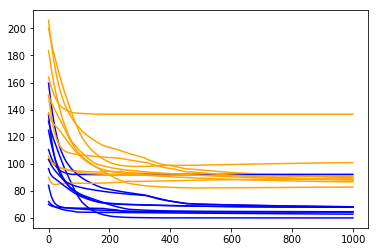

In [ ]:
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

# Diagnostics - vary number of neurons

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df = df.drop(0)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
    # separate
    X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
    # forecast dataset
    output = model.predict(X, batch_size=batch_size)
    # invert data transforms on forecast
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        # invert scaling
        yhat = invert_scale(scaler, X[i], yhat)
        # invert differencing
        yhat = yhat + raw_data[i]
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
    return rmse

# fit an MLP network to training data
def fit(train, test, raw, scaler, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    # prepare model
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=X.shape[1]))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit model
    train_rmse, test_rmse = list(), list()
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        # evaluate model on train data
        raw_train = raw[-(len(train)+len(test)+1):-len(test)]
        train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
        # evaluate model on test data
        raw_test = raw[-(len(test)+1):]
        test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
    history = DataFrame()
    history['train'], history['test'] = train_rmse, test_rmse
    return history

# run diagnostic experiments
def run():
    # config
    repeats = 10
    n_batch = 4
    n_epochs = 1000
    n_neurons = 2
    n_lag = 1
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    # run diagnostic tests
    for i in range(repeats):
        history = fit(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
        pyplot.plot(history['train'], color='blue')
        pyplot.plot(history['test'], color='orange')
        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
    pyplot.savefig('diagnostic_neurons.png')    

# entry point
run()

### Tuning: Varying the Number of Lagged Nodes in the Hidden Layer

In [ ]:
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

# Experiment - vary number of lagged inputs

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an MLP network to training data
def fit_model(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=X.shape[1]))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
    return model

# run a repeated experiment
def experiment(repeats, series, epochs, lag, neurons):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, lag)
    supervised_values = supervised.values[lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the model
        batch_size = 2
        model = fit_model(train_scaled, batch_size, epochs, neurons)
        # forecast test dataset
        test_reshaped = test_scaled[:,0:-1]
        output = model.predict(test_reshaped, batch_size=batch_size)
        predictions = list()
        for i in range(len(output)):
            yhat = output[i,0]
            X = test_scaled[i, 0:-1]
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

# load dataset
series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# experiment
repeats = 30
results = DataFrame()
epochs = 1000
# vary neurons
neurons = [1, 2, 3, 4, 5]
for n in neurons:
    results[str(n)] = experiment(repeats, series, epochs, n, n)
# summarize results
print(results.describe())
# save boxplot
results.boxplot()
pyplot.savefig('boxplot_neurons_lag.png')

1) Test RMSE: 92.582
2) Test RMSE: 92.586
3) Test RMSE: 91.454
4) Test RMSE: 136.254
5) Test RMSE: 92.567
6) Test RMSE: 92.583
7) Test RMSE: 91.593
8) Test RMSE: 92.607
9) Test RMSE: 92.588
10) Test RMSE: 91.366
11) Test RMSE: 136.041
12) Test RMSE: 92.613
13) Test RMSE: 136.376
14) Test RMSE: 92.584
15) Test RMSE: 91.035
16) Test RMSE: 136.525
17) Test RMSE: 91.362
18) Test RMSE: 135.727
19) Test RMSE: 91.058
20) Test RMSE: 92.056
21) Test RMSE: 92.595
22) Test RMSE: 91.701
23) Test RMSE: 92.206
24) Test RMSE: 135.706
25) Test RMSE: 92.586
26) Test RMSE: 91.675
27) Test RMSE: 92.584
28) Test RMSE: 92.560
29) Test RMSE: 135.442
30) Test RMSE: 92.596
1) Test RMSE: 115.804
2) Test RMSE: 137.854
3) Test RMSE: 97.274
4) Test RMSE: 98.053
5) Test RMSE: 97.492
6) Test RMSE: 97.434
7) Test RMSE: 83.652
8) Test RMSE: 84.397
9) Test RMSE: 97.874
10) Test RMSE: 97.948
11) Test RMSE: 114.699
12) Test RMSE: 84.077
13) Test RMSE: 102.985
14) Test RMSE: 94.228
15) Test RMSE: 135.732
16) Test RMSE: 9

**Conclusion: mean RMSE minimized with 3 lagged input nodes at 107 but the median is minimized with 1 lag at 93**

Using TensorFlow backend.


0) TrainRMSE=53.832241, TestRMSE=119.946553
1) TrainRMSE=53.070138, TestRMSE=107.711452
2) TrainRMSE=53.748653, TestRMSE=110.408484
3) TrainRMSE=48.364822, TestRMSE=100.081786
4) TrainRMSE=56.189363, TestRMSE=99.706806
5) TrainRMSE=59.284420, TestRMSE=107.047498
6) TrainRMSE=62.739612, TestRMSE=91.482962
7) TrainRMSE=51.795922, TestRMSE=114.155882
8) TrainRMSE=53.537881, TestRMSE=72.238459
9) TrainRMSE=47.149313, TestRMSE=126.758952


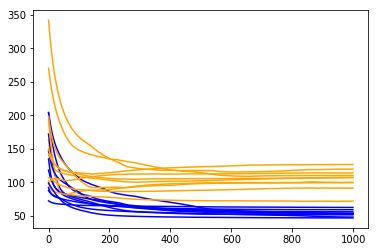

In [2]:
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

# Diagnostics- vary number of lagged inputs

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df = df.drop(0)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
    # separate
    X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
    # forecast dataset
    output = model.predict(X, batch_size=batch_size)
    # invert data transforms on forecast
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        # invert scaling
        yhat = invert_scale(scaler, X[i], yhat)
        # invert differencing
        yhat = yhat + raw_data[i]
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
    return rmse

# fit an MLP network to training data
def fit(train, test, raw, scaler, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    # prepare model
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=X.shape[1]))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit model
    train_rmse, test_rmse = list(), list()
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        # evaluate model on train data
        raw_train = raw[-(len(train)+len(test)+1):-len(test)]
        train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
        # evaluate model on test data
        raw_test = raw[-(len(test)+1):]
        test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
    history = DataFrame()
    history['train'], history['test'] = train_rmse, test_rmse
    return history
    
# run diagnostic experiments
def run():
    # config
    repeats = 10
    n_batch = 2
    n_epochs = 1000
    n_neurons = 3
    n_lag = 3
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    # run diagnostic tests
    for i in range(repeats):
        history = fit(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
        pyplot.plot(history['train'], color='blue')
        pyplot.plot(history['test'], color='orange')
        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
    pyplot.savefig('diagnostic_neurons_lag.png')    

# entry point
run()

### Review of ARIMA and MLP models for time series forecasting
***
**Conclusion: The tuned ARIMA performed better than the tuned MLP by 4%**

# LSTMs for Forecasting Time Series

## Data Prep - _Pivot time in rows to time in columns_

In [3]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat

# frame a sequence as a supervised learning problem
# FROM STACKED T IN ROWS TO T IN COLUMNS?
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# load dataset
datafile = '~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv'
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv(datafile, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# transform to supervised learning
X = series.values
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

       0      0
0    0.0  266.0
1  266.0  145.9
2  145.9  183.1
3  183.1  119.3
4  119.3  180.3


We now have 2 columns representing a 2 period time sequence: [y_t-1, y_t] 

### Transform Time Series to Stationary - Remove time trend by differencing: [y_diff] = [y_t - y_t-1]
***
This step comes from classical time series modeling. You can read more about **stationary processes** in time series [here](https://en.wikipedia.org/wiki/Stationary_process)

In [4]:
from pandas import read_csv
from pandas import datetime
from pandas import Series

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load dataset
datafile = '~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv'
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv(datafile, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
# transform to be stationary
differenced = difference(series, 1)
print(differenced.head())
# invert transform
inverted = list()
for i in range(len(differenced)):
	value = inverse_difference(series, differenced[i], len(series)-i)
	inverted.append(value)
inverted = Series(inverted)
print(inverted.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: shampooSales, dtype: float64
0   -120.1
1     37.2
2    -63.8
3     61.0
4    -11.8
dtype: float64
0    145.9
1    183.1
2    119.3
3    180.3
4    168.5
dtype: float64


### Transform Time Series to Scale
***
LSTM requires that the scale of the input data matches the scale of the activation function. The default activation for an LSTM in keras is the hyperbolic tangent function which outputs a min and max of [-1, 1] so we will transform our time series to match it.

In [5]:
from pandas import read_csv
from pandas import datetime
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
# load dataset
datafile = '~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv'
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv(datafile, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
# transform scale
X = series.values
X = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)
scaled_series = Series(scaled_X[:, 0])
print(scaled_series.head())
# invert transform
inverted_X = scaler.inverse_transform(scaled_X)
inverted_series = Series(inverted_X[:, 0])
print(inverted_series.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: shampooSales, dtype: float64
0   -0.478585
1   -0.905456
2   -0.773236
3   -1.000000
4   -0.783188
dtype: float64
0    266.0
1    145.9
2    183.1
3    119.3
4    180.3
dtype: float64


## LSTM Model Development Tips for Univariate Time Series
***
1. LSTM is 'stateful' like state-space model
        Benefit:
            a. Can learn and remember over long sequences
            b. Doesn't require pre-specified window of lagged observations as inputs (although we will test this in the feature engineering section)

2. LSTM layer in Keras maintains state between data within a batch, i.e., a fixed-sized number of rows from the training dataset that defines how many patterns to process before updating the weights of the network

3. State in the LSTM layer between batches is cleared by default. Therefore, to make an LSTM _stateful_ and control when state of the LSTM layer is cleared, we must use the reset_states() function

4. The LSTM layer in keras expects input to be in a matrix with the dimensions: [samples, time steps, features]
 a. _Samples_: These are independent observations from the domain, typically rows of data
 b. _Time steps_: These are separate time steps of a given variable for a given observation
 c. _Features_: These are separate measures observed at the time of observation

5. Shape of input data must be specified in LSTM layer using _batch_input_shape_ argument as a tuple that specifies: **(expected number of observations to read each batch, number of time steps, number of features)**

6. _Batch size_ is often much smaller than total number of samples and along with the number of epochs, defines how quickly then network learns the data; i.e., how often the weights are updated

7. The final import parameter defining the LSTM layer is _number of neurons_ (aka memory units or blocks) usually 1-5.

8. Example code:
        layer = LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True)
    
9. Network requires _single neuron in output layer_ using a _linear activation function_ to predict the number of shampoo sales at the next time step

10. Network specification then compiled in TF using a specific loss function and optimization algorithm:
        - Use “mean_squared_error” as the loss function (matches RMSE)
        - ADAM optimization algorithm (efficient)

11. Sequential Keras API example code:
 
        model = Sequential()
    
        model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    
        model.add(Dense(1))
    
        model.compile(loss='mean_squared_error', optimizer='adam')

12. Once LSTM is compiled, it can be fit to the training data 

13. Because the network is _stateful_, we must control _when the internal state is reset_; therefore, must manually manage training process one epoch at a time across desired number of epochs

14. By default, the samples within an epoch are _shuffled_ prior to being exposed to the network which is **undesirable for the Time-Series LSTM** because we want the network to build up state as it learns across the sequence of observations. We can _disable shuffling of samples by setting “shuffle” to “False“_

15. By default, network reports lots of debug info about learning progress and skill of model at end of each epoch. Can disable this by setting the _“verbose” argument to “0“_ 

16. **Example code**: loop manually fits network to the training data

    for i in range(nb_epoch):
    
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    
        model.reset_states()
    
17. **Batch_size** must be _set to 1_. This is because it must be a factor of the size of the training and test datasets

18. The _predict() function_ for model also _constrained by batch size_; therefore, **must be set to 1** because we are interested in making one-step forecasts on the test data

19. Network parameters are initialized at: **(Batch Size=1, Epochs=3000, Neurons=4)**
 
**Later, we will examine how to tune the hyper parameters to acheive better accuracy**

## LSTM Univariate _Single-Step_ Forecast of Shampoo Sales

Month=1, Predicted=224.605144, Expected=339.700000
Month=2, Predicted=333.210975, Expected=440.400000
Month=3, Predicted=261.654532, Expected=315.900000
Month=4, Predicted=389.605403, Expected=439.300000
Month=5, Predicted=180.982394, Expected=401.300000
Month=6, Predicted=299.582170, Expected=437.400000
Month=7, Predicted=242.553672, Expected=575.500000
Month=8, Predicted=181.652865, Expected=407.600000
Month=9, Predicted=231.514801, Expected=682.000000
Month=10, Predicted=362.571130, Expected=475.300000
Month=11, Predicted=226.574556, Expected=581.300000
Month=12, Predicted=244.668105, Expected=646.900000
Test RMSE: 252.133


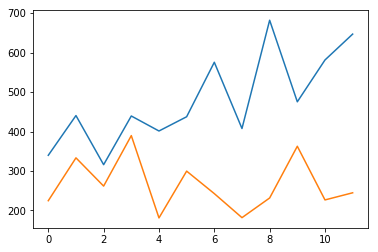

In [5]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# load dataset
datafile = '~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv'
series = read_csv(datafile, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

# Tuning Hyper Parameters in LSTM Forecast Model
***
Tuning parameters are: number of epochs, batch size, number of neurons

1) Test RMSE: 134.033
2) Test RMSE: 93.468
3) Test RMSE: 122.391
4) Test RMSE: 106.561
5) Test RMSE: 131.779
6) Test RMSE: 91.844
7) Test RMSE: 125.467
8) Test RMSE: 130.248
9) Test RMSE: 127.094
10) Test RMSE: 96.695
11) Test RMSE: 113.504
12) Test RMSE: 120.424
13) Test RMSE: 103.434
14) Test RMSE: 132.650
15) Test RMSE: 101.053
16) Test RMSE: 93.399
17) Test RMSE: 97.726
18) Test RMSE: 121.850
19) Test RMSE: 101.381
20) Test RMSE: 97.218
21) Test RMSE: 96.164
22) Test RMSE: 95.760
23) Test RMSE: 124.577
24) Test RMSE: 121.330
25) Test RMSE: 104.666
26) Test RMSE: 127.736
27) Test RMSE: 124.899
28) Test RMSE: 95.355
29) Test RMSE: 108.353
30) Test RMSE: 128.757
1) Test RMSE: 94.594
2) Test RMSE: 91.095
3) Test RMSE: 112.986
4) Test RMSE: 118.944
5) Test RMSE: 97.697
6) Test RMSE: 124.445
7) Test RMSE: 93.401
8) Test RMSE: 100.141
9) Test RMSE: 114.779
10) Test RMSE: 120.257
11) Test RMSE: 99.295
12) Test RMSE: 90.596
13) Test RMSE: 87.321
14) Test RMSE: 101.419
15) Test RMSE: 96.380


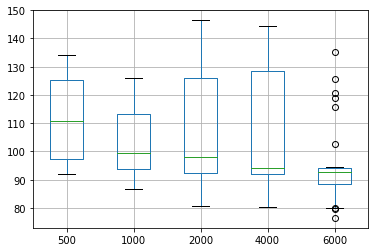

In [6]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df = df.drop(0)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# run a repeated experiment
def experiment(repeats, series, epochs):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the model
        batch_size = 4
        train_trimmed = train_scaled[2:, :]
        lstm_model = fit_lstm(train_trimmed, batch_size, epochs, 1)
        # forecast the entire training dataset to build up state for forecasting
        train_reshaped = train_trimmed[:, 0].reshape(len(train_trimmed), 1, 1)
        lstm_model.predict(train_reshaped, batch_size=batch_size)
        # forecast test dataset
        test_reshaped = test_scaled[:,0:-1]
        test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
        output = lstm_model.predict(test_reshaped, batch_size=batch_size)
        predictions = list()
        for i in range(len(output)):
            yhat = output[i,0]
            X = test_scaled[i, 0:-1]
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores


# load dataset
series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# experiment
repeats = 30
results = DataFrame()
# vary training epochs
epochs = [500, 1000, 2000, 4000, 6000]
for e in epochs:
    results[str(e)] = experiment(repeats, series, e)
# summarize results
print(results.describe())
# save boxplot
results.boxplot()
pyplot.savefig('boxplot_epochs.png')

# Feature Engineering in LSTM Forecast Model
***
### Experiment with 1 to 5 lagged inputs

1) Test RMSE: 118.529
2) Test RMSE: 129.855
3) Test RMSE: 204.171
4) Test RMSE: 103.701
5) Test RMSE: 118.994
6) Test RMSE: 134.015
7) Test RMSE: 99.087
8) Test RMSE: 180.944
9) Test RMSE: 110.554
10) Test RMSE: 97.982
          results
count   10.000000
mean   129.783008
std     35.614446
min     97.981690
25%    105.414240
50%    118.761370
75%    132.974795
max    204.170578
1) Test RMSE: 128.603
2) Test RMSE: 99.213
3) Test RMSE: 117.648
4) Test RMSE: 137.320
5) Test RMSE: 92.922
6) Test RMSE: 198.169
7) Test RMSE: 114.704
8) Test RMSE: 132.807
9) Test RMSE: 137.355
10) Test RMSE: 116.781
          results
count   10.000000
mean   127.552187
std     29.037329
min     92.921575
25%    115.223147
50%    123.125583
75%    136.191971
max    198.168771
1) Test RMSE: 126.499
2) Test RMSE: 189.396
3) Test RMSE: 155.284
4) Test RMSE: 127.860
5) Test RMSE: 112.888
6) Test RMSE: 136.845
7) Test RMSE: 105.272
8) Test RMSE: 121.239
9) Test RMSE: 108.076
10) Test RMSE: 273.635
          results

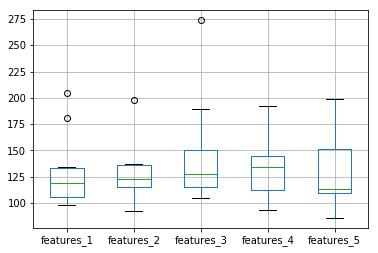

In [4]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# run a repeated experiment
def experiment(repeats, series, features):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, features)
    supervised_values = supervised.values[features:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the base model
        lstm_model = fit_lstm(train_scaled, 1, 500, 1)
        # forecast test dataset
        predictions = list()
        for i in range(len(test_scaled)):
            # predict
            X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, 1, X)
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

# execute the experiment - features = 1, neurons = 1
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    features = 1
    results['results'] = experiment(repeats, series, features)
    # summarize results
    print(results.describe())
    # save results
    results.to_csv('experiment_features_1.csv', index=False)

 # entry point
run()

# execute the experiment - features = 2, neurons = 1
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    features = 2
    results['results'] = experiment(repeats, series, features)
    # summarize results
    print(results.describe())
    # save results
    results.to_csv('experiment_features_2.csv', index=False)

 # entry point
run()

# execute the experiment - features = 3, neurons = 1
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    features = 3
    results['results'] = experiment(repeats, series, features)
    # summarize results
    print(results.describe())
    # save results
    results.to_csv('experiment_features_3.csv', index=False)

 # entry point
run()

# execute the experiment - features = 4, neurons = 1
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    features = 4
    results['results'] = experiment(repeats, series, features)
    # summarize results
    print(results.describe())
    # save results
    results.to_csv('experiment_features_4.csv', index=False)

 # entry point
run()

# execute the experiment - features = 5,  neurons = 1
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    features = 5
    results['results'] = experiment(repeats, series, features)
    # summarize results
    print(results.describe())
    # save results
    results.to_csv('experiment_features_5.csv', index=False)

 # entry point
run()


# Load experiments and compare
from pandas import DataFrame
from pandas import read_csv
from matplotlib import pyplot
# load results into a dataframe
filenames = ['experiment_features_1.csv', 'experiment_features_2.csv',
    'experiment_features_3.csv','experiment_features_4.csv','experiment_features_5.csv']
results = DataFrame()
for name in filenames:
    results[name[11:-4]] = read_csv(name, header=0)
# describe all results
print(results.describe())
# box and whisker plot
results.boxplot()
pyplot.show()

### Experiment with 1 to 5 lagged inputs and 1 to 5 neurons

1) Test RMSE: 110.683
2) Test RMSE: 101.406
3) Test RMSE: 91.916
4) Test RMSE: 86.845
5) Test RMSE: 118.524
6) Test RMSE: 102.002
7) Test RMSE: 222.989
8) Test RMSE: 92.607
9) Test RMSE: 92.774
10) Test RMSE: 110.948
          results
count   10.000000
mean   113.069288
std     39.925873
min     86.844736
25%     92.648440
50%    101.703857
75%    110.881536
max    222.989211
1) Test RMSE: 131.392
2) Test RMSE: 160.793
3) Test RMSE: 152.797
4) Test RMSE: 120.665
5) Test RMSE: 156.837
6) Test RMSE: 121.956
7) Test RMSE: 147.165
8) Test RMSE: 121.402
9) Test RMSE: 147.499
10) Test RMSE: 121.044
          results
count   10.000000
mean   138.155030
std     16.438062
min    120.664702
25%    121.540577
50%    139.278443
75%    151.472515
max    160.793170
1) Test RMSE: 118.139
2) Test RMSE: 132.837
3) Test RMSE: 105.429
4) Test RMSE: 152.111
5) Test RMSE: 104.176
6) Test RMSE: 110.620
7) Test RMSE: 115.541
8) Test RMSE: 126.597
9) Test RMSE: 133.536
10) Test RMSE: 262.693
          results

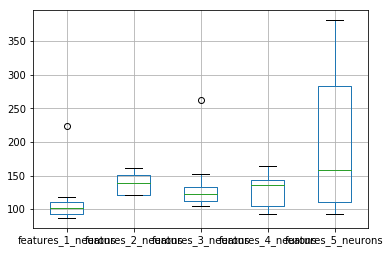

In [6]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# run a repeated experiment
def experiment(repeats, series, features):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, features)
    supervised_values = supervised.values[features:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the base model
        #lstm_model = fit_lstm(train_scaled, 1, 500, 1)
        lstm_model = fit_lstm(train_scaled, 1, 500, features)
        # forecast test dataset
        predictions = list()
        for i in range(len(test_scaled)):
            # predict
            X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, 1, X)
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

# execute the experiment - features = 1, neurons = 1
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    features = 1
    results['results'] = experiment(repeats, series, features)
    # summarize results
    print(results.describe())
    # save results
    #results.to_csv('experiment_features_1.csv', index=False)
    results.to_csv('experiment_features_1_neurons.csv', index=False)

 # entry point
run()

# execute the experiment - features = 2, neurons = 2
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    features = 2
    results['results'] = experiment(repeats, series, features)
    # summarize results
    print(results.describe())
    # save results
    #results.to_csv('experiment_features_2.csv', index=False)
    results.to_csv('experiment_features_2_neurons.csv', index=False)

 # entry point
run()

# execute the experiment - features = 3, neurons = 3
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    features = 3
    results['results'] = experiment(repeats, series, features)
    # summarize results
    print(results.describe())
    # save results
    #results.to_csv('experiment_features_3.csv', index=False)
    results.to_csv('experiment_features_3_neurons.csv', index=False)

 # entry point
run()

# execute the experiment - features = 4, neurons = 4
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    features = 4
    results['results'] = experiment(repeats, series, features)
    # summarize results
    print(results.describe())
    # save results
    #results.to_csv('experiment_features_4.csv', index=False)
    results.to_csv('experiment_features_4_neurons.csv', index=False)

 # entry point
run()

# execute the experiment - features = 5, neurons = 5
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    features = 5
    results['results'] = experiment(repeats, series, features)
    # summarize results
    print(results.describe())
    # save results
    #results.to_csv('experiment_features_5.csv', index=False)
    results.to_csv('experiment_features_5_neurons.csv', index=False)

 # entry point
run()

# Load experiments and compare
from pandas import DataFrame
from pandas import read_csv
from matplotlib import pyplot
# load results into a dataframe
filenames = ['experiment_features_1_neurons.csv', 'experiment_features_2_neurons.csv', 
             'experiment_features_3_neurons.csv','experiment_features_4_neurons.csv',
             'experiment_features_5_neurons.csv']
results = DataFrame()
for name in filenames:
    results[name[11:-4]] = read_csv(name, header=0)
# describe all results
print(results.describe())
# box and whisker plot
results.boxplot()
pyplot.show()

### Experiment with 1 to 5 lagged inputs and 1 to 5 neurons run for 1,000 epochs

Using TensorFlow backend.


1) Test RMSE: 106.814
2) Test RMSE: 225.960
3) Test RMSE: 93.893
4) Test RMSE: 251.305
5) Test RMSE: 98.642
6) Test RMSE: 96.892
7) Test RMSE: 99.783
8) Test RMSE: 101.196
9) Test RMSE: 95.443
10) Test RMSE: 90.784
          results
count   10.000000
mean   126.071113
std     59.781751
min     90.783848
25%     95.805224
50%     99.212189
75%    105.409112
max    251.305341
1) Test RMSE: 410.205
2) Test RMSE: 230.227
3) Test RMSE: 122.356
4) Test RMSE: 150.751
5) Test RMSE: 110.344
6) Test RMSE: 140.423
7) Test RMSE: 105.066
8) Test RMSE: 123.430
9) Test RMSE: 152.410
10) Test RMSE: 114.732
          results
count   10.000000
mean   165.994534
std     93.088061
min    105.066299
25%    116.638377
50%    131.926697
75%    151.995156
max    410.205021
1) Test RMSE: 109.724
2) Test RMSE: 91.870
3) Test RMSE: 141.976
4) Test RMSE: 169.411
5) Test RMSE: 101.320
6) Test RMSE: 474.412
7) Test RMSE: 113.825
8) Test RMSE: 192.425
9) Test RMSE: 132.546
10) Test RMSE: 261.994
          results
co

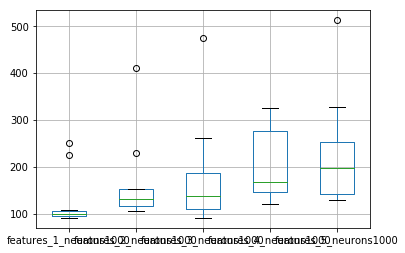

In [2]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# run a repeated experiment
def experiment(repeats, series, features):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, features)
    supervised_values = supervised.values[features:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the base model
        #lstm_model = fit_lstm(train_scaled, 1, 500, 1)
        #lstm_model = fit_lstm(train_scaled, 1, 500, features, features)
        lstm_model = fit_lstm(train_scaled, 1, 1000, features)
        # forecast test dataset
        predictions = list()
        for i in range(len(test_scaled)):
            # predict
            X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, 1, X)
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

# execute the experiment - Features = 1
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    features = 1
    results['results'] = experiment(repeats, series, features)
    # summarize results
    print(results.describe())
    # save results
    #results.to_csv('experiment_features_1.csv', index=False)
    #results.to_csv('experiment_features_1_neurons.csv', index=False)
    results.to_csv('experiment_features_1_neurons1000.csv', index=False)

 # entry point
run()

# execute the experiment - Features = 2
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    features = 2
    results['results'] = experiment(repeats, series, features)
    # summarize results
    print(results.describe())
    # save results
    #results.to_csv('experiment_features_2.csv', index=False)
    #results.to_csv('experiment_features_2_neurons.csv', index=False)
    results.to_csv('experiment_features_2_neurons1000.csv', index=False)

 # entry point
run()

# execute the experiment - Features = 3
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    features = 3
    results['results'] = experiment(repeats, series, features)
    # summarize results
    print(results.describe())
    # save results
    #results.to_csv('experiment_features_3.csv', index=False)
    #results.to_csv('experiment_features_3_neurons.csv', index=False)
    results.to_csv('experiment_features_3_neurons1000.csv', index=False)

 # entry point
run()

# execute the experiment - Features = 4
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    features = 4
    results['results'] = experiment(repeats, series, features)
    # summarize results
    print(results.describe())
    # save results
    #results.to_csv('experiment_features_4.csv', index=False)
    #results.to_csv('experiment_features_4_neurons.csv', index=False)
    results.to_csv('experiment_features_4_neurons1000.csv', index=False)

 # entry point
run()

# execute the experiment - Features = 5
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    features = 5
    results['results'] = experiment(repeats, series, features)
    # summarize results
    print(results.describe())
    # save results
    #results.to_csv('experiment_features_5.csv', index=False)
    #results.to_csv('experiment_features_5_neurons.csv', index=False)
    results.to_csv('experiment_features_5_neurons1000.csv', index=False)

 # entry point
run()


# Load experiments and compare
from pandas import DataFrame
from pandas import read_csv
from matplotlib import pyplot
# load results into a dataframe
filenames = ['experiment_features_1_neurons1000.csv', 'experiment_features_2_neurons1000.csv', 
             'experiment_features_3_neurons1000.csv','experiment_features_4_neurons1000.csv',
             'experiment_features_5_neurons1000.csv']
results = DataFrame()
for name in filenames:
    results[name[11:-4]] = read_csv(name, header=0)
# describe all results
print(results.describe())
# box and whisker plot
results.boxplot()
pyplot.show()

# Stateful vs Stateless LSTM Forecast Models
***
In order to understand and leverage memory in an LSTM, it is helpful to see the defition of _stateful_ for an LSTM layer in the [keras source code](https://github.com/keras-team/keras/blob/b21764824f181fb7a32fce852e5afcee4042192a/keras/layers/recurrent.py#L2025) which I have reproduced below:

    stateful: Boolean (default False). If True, the last state
            for each sample at index i in a batch will be used as initial
            state for the sample of index i in the following batch
            
Summarizing, for each batch (i.e. group of samples or cases in the training data) a _stateful_ LSTM will remember the cell state (Ct-1 in the diagram above) and use it as an input to calculate the current state (Ct).

**Stateless LSTM:** Internal state reset after each training batch OR each batch when making predictions

**Stateful LSTM:** Internal state is only reset when the reset_state() function is called

### Baseline Model: A vs A Test

1) Test RMSE: 267.577
2) Test RMSE: 98.265
3) Test RMSE: 100.788
4) Test RMSE: 217.482
5) Test RMSE: 98.432
6) Test RMSE: 103.671
7) Test RMSE: 104.545
8) Test RMSE: 91.174
9) Test RMSE: 107.421
10) Test RMSE: 120.440
          results
count   10.000000
mean   130.979506
std     60.440870
min     91.174473
25%     99.020677
50%    104.107676
75%    117.185476
max    267.577224
1) Test RMSE: 91.898
2) Test RMSE: 87.957
3) Test RMSE: 99.413
4) Test RMSE: 101.699
5) Test RMSE: 116.946
6) Test RMSE: 250.015
7) Test RMSE: 93.503
8) Test RMSE: 99.969
9) Test RMSE: 101.844
10) Test RMSE: 103.944
          results
count   10.000000
mean   114.718664
std     48.189762
min     87.956650
25%     94.980132
50%    100.834032
75%    103.419093
max    250.014766
         stateful   stateful2
count   10.000000   10.000000
mean   130.979506  114.718664
std     60.440870   48.189762
min     91.174473   87.956650
25%     99.020677   94.980132
50%    104.107676  100.834032
75%    117.185476  103.419093
ma

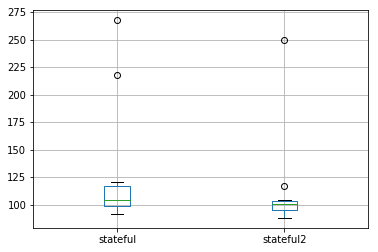

In [14]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# run a repeated experiment
def experiment(repeats, series):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values[1:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the base model
        lstm_model = fit_lstm(train_scaled, 1, 1000, 1)
        # forecast test dataset
        predictions = list()
        for i in range(len(test_scaled)):
            # predict
            X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, 1, X)
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

# execute the experiment - generate experiment_stateful.csv
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    results['results'] = experiment(repeats, series)
    # summarize results
    print(results.describe())
    # save results
    results.to_csv('experiment_stateful.csv', index=False)

 # entry point
run()

# execute the experiment - generate experiment_stateful2.csv
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    results['results'] = experiment(repeats, series)
    # summarize results
    print(results.describe())
    # save results
    results.to_csv('experiment_stateful2.csv', index=False)

 # entry point
run()

# Compare versions of stateful LSTMs
from pandas import DataFrame
from pandas import read_csv
from matplotlib import pyplot
# load results into a dataframe
filenames = ['experiment_stateful.csv', 'experiment_stateful2.csv']
results = DataFrame()
for name in filenames:
    results[name[11:-4]] = read_csv(name, header=0)
# describe all results
print(results.describe())
# box and whisker plot
results.boxplot()
pyplot.show()

### Compare Stateful and Stateless LSTMs

1) Test RMSE: 94.932
2) Test RMSE: 93.048
3) Test RMSE: 94.572
4) Test RMSE: 93.811
5) Test RMSE: 97.160
6) Test RMSE: 95.668
7) Test RMSE: 97.374
8) Test RMSE: 95.596
9) Test RMSE: 95.218
10) Test RMSE: 94.083
         results
count  10.000000
mean   95.146155
std     1.382063
min    93.048261
25%    94.205094
50%    95.074933
75%    95.649761
max    97.373776
1) Test RMSE: 93.884
2) Test RMSE: 93.123
3) Test RMSE: 93.622
4) Test RMSE: 93.502
5) Test RMSE: 93.915
6) Test RMSE: 96.037
7) Test RMSE: 94.790
8) Test RMSE: 96.438
9) Test RMSE: 95.909
10) Test RMSE: 94.440
         results
count  10.000000
mean   94.565937
std     1.180139
min    93.122670
25%    93.687149
50%    94.177482
75%    95.628894
max    96.438371
         stateful  stateless  stateless_shuffle
count   10.000000  10.000000          10.000000
mean   130.979506  95.146155          94.565937
std     60.440870   1.382063           1.180139
min     91.174473  93.048261          93.122670
25%     99.020677  94.205094    

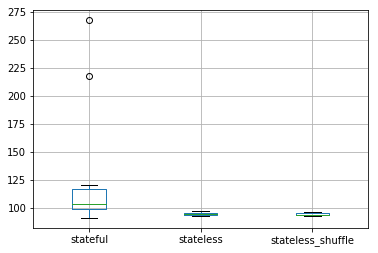

In [16]:
# fit an LSTM network to training data - for stateless lstm
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=False))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
    return model

# execute the experiment - generate experiment_stateless.csv
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    results['results'] = experiment(repeats, series)
    # summarize results
    print(results.describe())
    # save results
    results.to_csv('experiment_stateless.csv', index=False)

 # entry point
run()


# fit an LSTM network to training data - for stateless lstm with shuffling
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=False))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=True)
    return model

# execute the experiment - generate experiment_stateless.csv
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    results['results'] = experiment(repeats, series)
    # summarize results
    print(results.describe())
    # save results
    results.to_csv('experiment_stateless_shuffle.csv', index=False)

 # entry point
run()

# Compare results
from pandas import DataFrame
from pandas import read_csv
from matplotlib import pyplot
# load results into a dataframe
filenames = ['experiment_stateful.csv', 'experiment_stateless.csv', 'experiment_stateless_shuffle.csv']
results = DataFrame()
for name in filenames:
    results[name[11:-4]] = read_csv(name, header=0)
# describe all results
print(results.describe())
# box and whisker plot
results.boxplot()
pyplot.show()

### Compare Stateless to Stateful LSTM when using the same batch size
***

**experiment_stateful_batch12.csv**

In [3]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# run a repeated experiment
def experiment(repeats, series):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values[1:,:]
    # split data into train and test-sets
    train, test = supervised_values[-24:-12, :], supervised_values[-12:, :]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the base model
        batch_size = 12
        lstm_model = fit_lstm(train_scaled, batch_size, 1000, 1)
        # forecast test dataset
        test_reshaped = test_scaled[:,0:-1]
        test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
        output = lstm_model.predict(test_reshaped, batch_size=batch_size)
        predictions = list()
        for i in range(len(output)):
            yhat = output[i,0]
            X = test_scaled[i, 0:-1]
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

# execute the experiment - generate experiment_stateful.csv
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    results['results'] = experiment(repeats, series)
    # summarize results
    print(results.describe())
    # save results
    results.to_csv('experiment_stateful_batch12.csv', index=False)

 # entry point
run()

1) Test RMSE: 102.752
2) Test RMSE: 125.691
3) Test RMSE: 96.963
4) Test RMSE: 92.622
5) Test RMSE: 99.304
6) Test RMSE: 96.166
7) Test RMSE: 120.480
8) Test RMSE: 97.003
9) Test RMSE: 113.098
10) Test RMSE: 90.947
          results
count   10.000000
mean   103.502832
std     12.044763
min     90.946938
25%     96.365711
50%     98.153668
75%    110.511548
max    125.691167


**experiment_stateless_batch12.csv**

In [4]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=False))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# run a repeated experiment
def experiment(repeats, series):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values[1:,:]
    # split data into train and test-sets
    train, test = supervised_values[-24:-12, :], supervised_values[-12:, :]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the base model
        batch_size = 12
        lstm_model = fit_lstm(train_scaled, batch_size, 1000, 1)
        # forecast test dataset
        test_reshaped = test_scaled[:,0:-1]
        test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
        output = lstm_model.predict(test_reshaped, batch_size=batch_size)
        predictions = list()
        for i in range(len(output)):
            yhat = output[i,0]
            X = test_scaled[i, 0:-1]
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

# execute the experiment - generate experiment_stateful.csv
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    results['results'] = experiment(repeats, series)
    # summarize results
    print(results.describe())
    # save results
    results.to_csv('experiment_stateless_batch12.csv', index=False)

 # entry point
run()

1) Test RMSE: 97.266
2) Test RMSE: 119.840
3) Test RMSE: 101.615
4) Test RMSE: 95.264
5) Test RMSE: 102.686
6) Test RMSE: 92.555
7) Test RMSE: 91.202
8) Test RMSE: 132.661
9) Test RMSE: 133.938
10) Test RMSE: 134.070
          results
count   10.000000
mean   110.109764
std     18.022865
min     91.202370
25%     95.764552
50%    102.150704
75%    129.455498
max    134.070327


Compare **stateful** and **stateless** with same batch size

       stateful_batch12  stateless_batch12
count         10.000000          10.000000
mean         103.502832         110.109764
std           12.044763          18.022865
min           90.946938          91.202370
25%           96.365711          95.764552
50%           98.153668         102.150704
75%          110.511548         129.455498
max          125.691167         134.070327


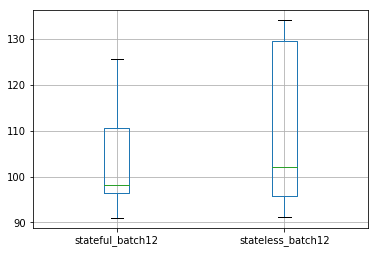

In [5]:
from pandas import DataFrame
from pandas import read_csv
from matplotlib import pyplot
# load results into a dataframe
filenames = ['experiment_stateful_batch12.csv', 'experiment_stateless_batch12.csv']
results = DataFrame()
for name in filenames:
    results[name[11:-4]] = read_csv(name, header=0)
# describe all results
print(results.describe())
# box and whisker plot
results.boxplot()
pyplot.show()

### Stateful Resetting vs Stateless LSTM
***

### Experimental Design

This experiment explores different combinations of **resetting the state** during training and predictions and **seeding the model** by making predictions on the training data prior to predicting the test data. 

There are three variations of **resetting** the training and test data tested: 

1. Reset on **training data** but **not test data**

2. Reset on **both training** and **test data**

3. Do **not reset** either the **training** or **test data**

Since **seeding the model** only has two variations: **seed** or **not seed**. Together resetting and seeding produces six different combinations to test which are described below.

**No Seeding**

**noseed_1** Reset state after each training epoch and not during testing (**experiment_stateful.csv**)

**noseed_2:** Reset state after each training epoch and after each one-step prediction (**experiment_stateful_reset_test.csv**)

**noseed_3:** No resets after training or making one-step predictions (**experiment_stateful_noreset.csv**)


**Seeding**

**seed_1:** Reset state after each training epoch, seed state with one-step predictions on training dataset before making one-step predictions on the test dataset (**experiment_stateful_seed_train.csv**)

**seed_2:** Reset state after each training epoch, seed state with one-step predictions on training dataset before making one-step predictions on the test dataset and reset state after each one-step prediction on train and test sets (**experiment_stateful_seed_train_resets.csv**)

**seed_3:** Seed on training dataset before making one-step predictions, no resets during training on predictions (**experiment_stateful_seed_train_no_resets.csv**)
***
### No Seed

In [6]:
# noseed_1 - Reset state after each training epoch and not during testing - first experiment
# - experiment_stateful.csv

# noseed_2 - Reset state after each training epoch and after each one-step prediction
# - experiment_stateful_reset_test.csv

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    return model

# make a one-step forecast - add model.reset_states()
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    model.reset_states()
    return yhat[0,0]

# run a repeated experiment
def experiment(repeats, series):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values[1:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the base model
        lstm_model = fit_lstm(train_scaled, 1, 1000, 1)
        # forecast train dataset
        for i in range(len(train_scaled)):
            X, y = train_scaled[i, 0:-1], train_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, 1, X)
        # forecast test dataset
        predictions = list()
        for i in range(len(test_scaled)):
            # predict
            X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, 1, X)
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

# execute the experiment - generate experiment_stateful.csv
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    results['results'] = experiment(repeats, series)
    # summarize results
    print(results.describe())
    # save results
    results.to_csv('experiment_stateful_reset_test.csv', index=False)

 # entry point
run()

1) Test RMSE: 108.131
2) Test RMSE: 118.356
3) Test RMSE: 99.526
4) Test RMSE: 115.172
5) Test RMSE: 104.096
6) Test RMSE: 107.581
7) Test RMSE: 101.117
8) Test RMSE: 105.832
9) Test RMSE: 117.497
10) Test RMSE: 108.156
          results
count   10.000000
mean   108.546297
std      6.542472
min     99.525712
25%    104.529845
50%    107.856082
75%    113.418175
max    118.355581


In [7]:
# noseed_3 - No resets after training or making one-step predictions 
# - experiment_stateful_noreset.csv

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# run a repeated experiment
def experiment(repeats, series):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values[1:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the base model
        lstm_model = fit_lstm(train_scaled, 1, 1000, 1)
        # forecast train dataset
        for i in range(len(train_scaled)):
            X, y = train_scaled[i, 0:-1], train_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, 1, X)
        # forecast test dataset
        predictions = list()
        for i in range(len(test_scaled)):
            # predict
            X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, 1, X)
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

# execute the experiment - generate experiment_stateful_noreset.csv
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    results['results'] = experiment(repeats, series)
    # summarize results
    print(results.describe())
    # save results
    results.to_csv('experiment_stateful_noreset.csv', index=False)

 # entry point
run()

1) Test RMSE: 103.850
2) Test RMSE: 113.362
3) Test RMSE: 104.682
4) Test RMSE: 90.611
5) Test RMSE: 95.742
6) Test RMSE: 87.391
7) Test RMSE: 89.812
8) Test RMSE: 112.776
9) Test RMSE: 96.672
10) Test RMSE: 102.278
          results
count   10.000000
mean    99.717589
std      9.207744
min     87.391267
25%     91.893981
50%     99.474860
75%    104.473953
max    113.362410


### Seed

In [8]:
# seed_1: Reset state after each training epoch, 
# seed state with one-step predictions on training dataset before making one-step predictions on the test dataset 
# RESET_STATES ON FIT BUT NOT FORECAST FUNC
# - experiment_stateful_seed_train.csv

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# run a repeated experiment
def experiment(repeats, series):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values[1:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the base model
        lstm_model = fit_lstm(train_scaled, 1, 1000, 1)
        # forecast train dataset
        for i in range(len(train_scaled)):
            X, y = train_scaled[i, 0:-1], train_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, 1, X)
        # forecast test dataset
        predictions = list()
        for i in range(len(test_scaled)):
            # predict
            X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, 1, X)
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

# execute the experiment - generate experiment_stateful.csv
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    results['results'] = experiment(repeats, series)
    # summarize results
    print(results.describe())
    # save results
    results.to_csv('experiment_stateful_seed_train.csv', index=False)

 # entry point
run()

1) Test RMSE: 100.238
2) Test RMSE: 103.063
3) Test RMSE: 98.318
4) Test RMSE: 116.062
5) Test RMSE: 104.256
6) Test RMSE: 99.733
7) Test RMSE: 101.483
8) Test RMSE: 104.705
9) Test RMSE: 105.994
10) Test RMSE: 92.470
          results
count   10.000000
mean   102.632222
std      6.111057
min     92.470231
25%     99.859101
50%    102.273173
75%    104.592423
max    116.061686


In [9]:
# seed_2: Reset state after each training epoch, 
# seed state with one-step predictions on training dataset before making one-step predictions on the test dataset and 
# reset state after each one-step prediction on train and test sets 
# RESET_STATES ON BOTH FIT AND FORECAST FUNCS
# - experiment_stateful_seed_train_resets.csv

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast - call reset_states()
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    model.reset_states()
    return yhat[0,0]

# run a repeated experiment
def experiment(repeats, series):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values[1:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the base model
        lstm_model = fit_lstm(train_scaled, 1, 1000, 1)
        # forecast train dataset
        for i in range(len(train_scaled)):
            X, y = train_scaled[i, 0:-1], train_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, 1, X)
        # forecast test dataset
        predictions = list()
        for i in range(len(test_scaled)):
            # predict
            X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, 1, X)
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

# execute the experiment - generate experiment_stateful.csv
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    results['results'] = experiment(repeats, series)
    # summarize results
    print(results.describe())
    # save results
    results.to_csv('experiment_stateful_seed_train_resets.csv', index=False)

 # entry point
run()


1) Test RMSE: 101.513
2) Test RMSE: 178.839
3) Test RMSE: 92.911
4) Test RMSE: 107.801
5) Test RMSE: 147.079
6) Test RMSE: 102.974
7) Test RMSE: 118.432
8) Test RMSE: 126.131
9) Test RMSE: 106.929
10) Test RMSE: 100.007
          results
count   10.000000
mean   118.261523
std     26.436504
min     92.910903
25%    101.877927
50%    107.365166
75%    124.206204
max    178.838710


In [10]:
# seed_3: Seed on training dataset before making one-step predictions, 
# no resets during training on predictions
# NO RESET_STATES ON EITHER FIT AND FORECAST FUNCS
# - experiment_stateful_seed_train_no_resets.csv

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    return model

# make a one-step forecast - add model.reset_states()
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    #model.reset_states()
    return yhat[0,0]

# run a repeated experiment
def experiment(repeats, series):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values[1:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the base model
        lstm_model = fit_lstm(train_scaled, 1, 1000, 1)
        # forecast train dataset
        for i in range(len(train_scaled)):
            X, y = train_scaled[i, 0:-1], train_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, 1, X)
        # forecast test dataset
        predictions = list()
        for i in range(len(test_scaled)):
            # predict
            X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, 1, X)
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

# execute the experiment - generate experiment_stateful.csv
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    results['results'] = experiment(repeats, series)
    # summarize results
    print(results.describe())
    # save results
    results.to_csv('experiment_stateful_seed_train_no_resets.csv', index=False)

 # entry point
run()

1) Test RMSE: 98.473
2) Test RMSE: 110.384
3) Test RMSE: 106.920
4) Test RMSE: 88.282
5) Test RMSE: 92.411
6) Test RMSE: 104.039
7) Test RMSE: 89.748
8) Test RMSE: 134.823
9) Test RMSE: 102.255
10) Test RMSE: 111.974
          results
count   10.000000
mean   103.930838
std     13.666551
min     88.282006
25%     93.926079
50%    103.147189
75%    109.517747
max    134.823206


         noseed_1    noseed_2    noseed_3      seed_1      seed_2      seed_3
count   10.000000   10.000000   10.000000   10.000000   10.000000   10.000000
mean   113.702471  108.546297   99.717589  102.632222  118.261523  103.930838
std     24.297591    6.542472    9.207744    6.111057   26.436504   13.666551
min     96.321404   99.525712   87.391267   92.470231   92.910903   88.282006
25%    102.966803  104.529845   91.893981   99.859101  101.877927   93.926079
50%    105.462602  107.856082   99.474860  102.273173  107.365166  103.147189
75%    109.724914  113.418175  104.473953  104.592423  124.206204  109.517747
max    179.734075  118.355581  113.362410  116.061686  178.838710  134.823206


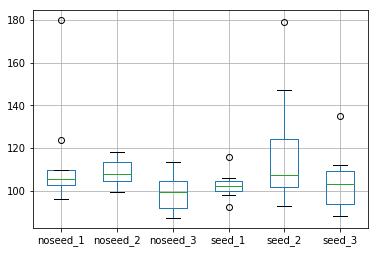

In [11]:
from pandas import DataFrame
from pandas import read_csv
from matplotlib import pyplot
# load results into a dataframe
filenames = ['experiment_stateful.csv', 'experiment_stateful_reset_test.csv',
    'experiment_stateful_noreset.csv', 'experiment_stateful_seed_train.csv',
    'experiment_stateful_seed_train_resets.csv', 'experiment_stateful_seed_train_no_resets.csv']
results = DataFrame()
for name in filenames:
    results[name] = read_csv(name, header=0)
results.columns = ['noseed_1', 'noseed_2', 'noseed_3', 'seed_1', 'seed_2', 'seed_3']
# describe all results
print(results.describe())
# box and whisker plot
results.boxplot()
pyplot.show()

### Conclusion - Stateful vs Stateless LSTM Experiments
***
1. Stateless LSTMs performed better than stateful models with the same configuration.

2. Do not reshuffle cases during training of the stateless model

3. Stateless and stateful perform the same with similar batch sizes

When using a stateful model either:

* **Reset the state** on **both training and test data** and do **NOT seed the model** OR

* Do **NOT reset the state** on the training or test data but **seed the model**



# Tuning LSTM Forecasting Model using Dropout Regularization
***
Dropout regularization helps to reduce overfitting by randomly excluding input and recurrent nodes from being updated during training. 

In keras, input dropout is specified using the _dropout_ argument when creating an LSTM layer. Recurrent node dropout is specified using the _recurrent_dropout_ argument in the LSTM layer.

1) Test RMSE: 101.060
2) Test RMSE: 100.505
3) Test RMSE: 98.028
4) Test RMSE: 100.022
5) Test RMSE: 95.491
6) Test RMSE: 101.298
7) Test RMSE: 106.059
8) Test RMSE: 106.241
9) Test RMSE: 108.835
10) Test RMSE: 102.977
11) Test RMSE: 102.618
12) Test RMSE: 97.163
13) Test RMSE: 96.638
14) Test RMSE: 93.696
15) Test RMSE: 102.274
16) Test RMSE: 108.518
17) Test RMSE: 98.122
18) Test RMSE: 98.586
19) Test RMSE: 100.256
20) Test RMSE: 90.497
21) Test RMSE: 96.190
22) Test RMSE: 95.302
23) Test RMSE: 95.381
24) Test RMSE: 89.191
25) Test RMSE: 100.172
26) Test RMSE: 91.370
27) Test RMSE: 107.854
28) Test RMSE: 90.913
29) Test RMSE: 99.016
30) Test RMSE: 98.961
          results
count   30.000000
mean    99.107869
std      5.255998
min     89.190508
25%     95.665911
50%     98.988527
75%    102.030334
max    108.835312


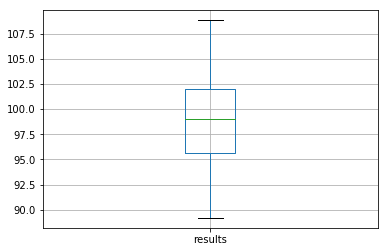

In [3]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, n_batch, nb_epoch, n_neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

# run a repeated experiment
def experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(n_repeats):
        # fit the model
        train_trimmed = train_scaled[2:, :]
        lstm_model = fit_lstm(train_trimmed, n_batch, n_epochs, n_neurons)
        # forecast test dataset
        test_reshaped = test_scaled[:,0:-1]
        test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
        output = lstm_model.predict(test_reshaped, batch_size=n_batch)
        predictions = list()
        for i in range(len(output)):
            yhat = output[i,0]
            X = test_scaled[i, 0:-1]
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

# configure the experiment
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # configure the experiment
    n_lag = 1
    n_repeats = 30
    n_epochs = 1000
    n_batch = 4
    n_neurons = 3
    # run the experiment
    results = DataFrame()
    results['results'] = experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons)
    # summarize results
    print(results.describe())
    # save boxplot
    results.boxplot()
    pyplot.savefig('experiment_baseline.png')

# entry point
run()

### LSTM Dropout Diagnostics

1) TrainRMSE=59.367562, TestRMSE=92.233967
2) TrainRMSE=61.669250, TestRMSE=93.298953
3) TrainRMSE=62.207426, TestRMSE=104.383579
4) TrainRMSE=63.568612, TestRMSE=104.126006
5) TrainRMSE=66.577196, TestRMSE=100.087364
6) TrainRMSE=57.879877, TestRMSE=98.830371
7) TrainRMSE=59.497592, TestRMSE=100.849892
8) TrainRMSE=62.702976, TestRMSE=107.676466
9) TrainRMSE=66.917432, TestRMSE=96.131824
10) TrainRMSE=63.353085, TestRMSE=95.569169


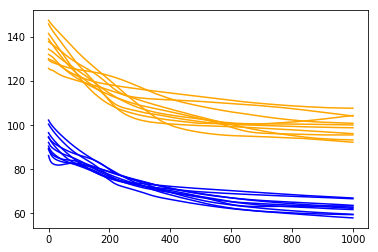

In [4]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
    # separate
    X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
    # reshape
    reshaped = X.reshape(len(X), 1, 1)
    # forecast dataset
    output = model.predict(reshaped, batch_size=batch_size)
    # invert data transforms on forecast
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        # invert scaling
        yhat = invert_scale(scaler, X[i], yhat)
        # invert differencing
        yhat = yhat + raw_data[i]
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
    # reset model state
    model.reset_states()
    return rmse

# fit an LSTM network to training data
def fit_lstm(train, test, raw, scaler, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # prepare model
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit model
    train_rmse, test_rmse = list(), list()
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
        # evaluate model on train data
        raw_train = raw[-(len(train)+len(test)+1):-len(test)]
        train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
        # evaluate model on test data
        raw_test = raw[-(len(test)+1):]
        test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
    history = DataFrame()
    history['train'], history['test'] = train_rmse, test_rmse
    return history

# run diagnostic experiments
def run():
    # config
    n_lag = 1
    n_repeats = 10
    n_epochs = 1000
    n_batch = 4
    n_neurons = 3
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    # run diagnostic tests
    for i in range(n_repeats):
        history = fit_lstm(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
        pyplot.plot(history['train'], color='blue')
        pyplot.plot(history['test'], color='orange')
        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i+1, history['train'].iloc[-1], history['test'].iloc[-1]))
    pyplot.savefig('diagnostic_baseline.png')

# entry point
run()

### LSTM with Input Dropout

Using TensorFlow backend.


1) Test RMSE: 104.594
2) Test RMSE: 102.995
3) Test RMSE: 98.761
4) Test RMSE: 92.492
5) Test RMSE: 98.120
6) Test RMSE: 95.226
7) Test RMSE: 102.149
8) Test RMSE: 100.642
9) Test RMSE: 89.073
10) Test RMSE: 95.300
11) Test RMSE: 101.563
12) Test RMSE: 90.859
13) Test RMSE: 98.692
14) Test RMSE: 102.916
15) Test RMSE: 94.466
16) Test RMSE: 98.434
17) Test RMSE: 93.263
18) Test RMSE: 96.613
19) Test RMSE: 101.742
20) Test RMSE: 100.718
21) Test RMSE: 104.605
22) Test RMSE: 100.237
23) Test RMSE: 101.126
24) Test RMSE: 100.546
25) Test RMSE: 114.616
26) Test RMSE: 99.703
27) Test RMSE: 105.663
28) Test RMSE: 97.851
29) Test RMSE: 98.885
30) Test RMSE: 107.266
1) Test RMSE: 98.654
2) Test RMSE: 102.499
3) Test RMSE: 98.723
4) Test RMSE: 97.118
5) Test RMSE: 97.661
6) Test RMSE: 97.039
7) Test RMSE: 96.385
8) Test RMSE: 95.849
9) Test RMSE: 101.628
10) Test RMSE: 99.379
11) Test RMSE: 94.405
12) Test RMSE: 105.320
13) Test RMSE: 101.433
14) Test RMSE: 92.672
15) Test RMSE: 93.953
16) Test 

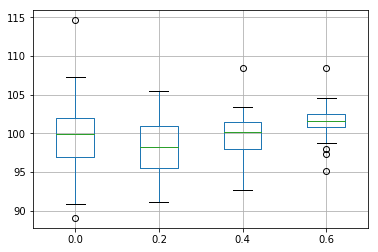

In [3]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, n_batch, nb_epoch, n_neurons, dropout):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, dropout=dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

# run a repeated experiment
def experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons, dropout):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(n_repeats):
        # fit the model
        train_trimmed = train_scaled[2:, :]
        lstm_model = fit_lstm(train_trimmed, n_batch, n_epochs, n_neurons, dropout)
        # forecast test dataset
        test_reshaped = test_scaled[:,0:-1]
        test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
        output = lstm_model.predict(test_reshaped, batch_size=n_batch)
        predictions = list()
        for i in range(len(output)):
            yhat = output[i,0]
            X = test_scaled[i, 0:-1]
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

# configure the experiment
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # configure the experiment
    n_lag = 1
    n_repeats = 30
    n_epochs = 1000
    n_batch = 4
    n_neurons = 3
    n_dropout = [0.0, 0.2, 0.4, 0.6]
    # run the experiment
    results = DataFrame()
    for dropout in n_dropout:
        results[str(dropout)] = experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons, dropout)
    # summarize results
    print(results.describe())
    # save boxplot
    results.boxplot()
    pyplot.savefig('experiment_dropout_input.png')
    
# entry point
run()

### Diagnostics for Input Dropout

1) TrainRMSE=67.101294, TestRMSE=101.538031
2) TrainRMSE=68.301591, TestRMSE=102.850005
3) TrainRMSE=65.146660, TestRMSE=94.030762
4) TrainRMSE=64.123667, TestRMSE=101.084970
5) TrainRMSE=61.396745, TestRMSE=96.905191
6) TrainRMSE=67.355017, TestRMSE=96.791741
7) TrainRMSE=67.254694, TestRMSE=101.180304
8) TrainRMSE=69.020157, TestRMSE=99.216953
9) TrainRMSE=63.983324, TestRMSE=95.611367
10) TrainRMSE=64.869043, TestRMSE=96.859386


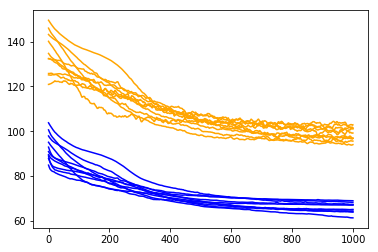

In [4]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
    # separate
    X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
    # reshape
    reshaped = X.reshape(len(X), 1, 1)
    # forecast dataset
    output = model.predict(reshaped, batch_size=batch_size)
    # invert data transforms on forecast
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        # invert scaling
        yhat = invert_scale(scaler, X[i], yhat)
        # invert differencing
        yhat = yhat + raw_data[i]
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
    # reset model state
    model.reset_states()
    return rmse

# fit an LSTM network to training data
def fit_lstm(train, test, raw, scaler, batch_size, nb_epoch, neurons, dropout):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # prepare model
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True, dropout=dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit model
    train_rmse, test_rmse = list(), list()
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
        # evaluate model on train data
        raw_train = raw[-(len(train)+len(test)+1):-len(test)]
        train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
        # evaluate model on test data
        raw_test = raw[-(len(test)+1):]
        test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
    history = DataFrame()
    history['train'], history['test'] = train_rmse, test_rmse
    return history

# run diagnostic experiments
def run():
    # config
    n_lag = 1
    n_repeats = 10
    n_epochs = 1000
    n_batch = 4
    n_neurons = 3
    dropout = 0.4
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    # run diagnostic tests
    for i in range(n_repeats):
        history = fit_lstm(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons, dropout)
        pyplot.plot(history['train'], color='blue')
        pyplot.plot(history['test'], color='orange')
        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i+1, history['train'].iloc[-1], history['test'].iloc[-1]))
    pyplot.savefig('diagnostic_dropout_input.png')

# entry point
run()

### LSTM with Recurrent Dropout

1) Test RMSE: 103.002
2) Test RMSE: 101.679
3) Test RMSE: 97.262
4) Test RMSE: 99.481
5) Test RMSE: 101.650
6) Test RMSE: 98.218
7) Test RMSE: 94.462
8) Test RMSE: 101.724
9) Test RMSE: 96.425
10) Test RMSE: 89.855
11) Test RMSE: 106.301
12) Test RMSE: 97.667
13) Test RMSE: 96.314
14) Test RMSE: 100.761
15) Test RMSE: 97.732
16) Test RMSE: 96.358
17) Test RMSE: 92.424
18) Test RMSE: 92.149
19) Test RMSE: 91.474
20) Test RMSE: 105.720
21) Test RMSE: 101.514
22) Test RMSE: 111.523
23) Test RMSE: 93.489
24) Test RMSE: 94.179
25) Test RMSE: 100.050
26) Test RMSE: 96.017
27) Test RMSE: 98.846
28) Test RMSE: 97.626
29) Test RMSE: 95.448
30) Test RMSE: 100.621
1) Test RMSE: 91.667
2) Test RMSE: 94.138
3) Test RMSE: 95.642
4) Test RMSE: 92.358
5) Test RMSE: 93.798
6) Test RMSE: 97.191
7) Test RMSE: 97.073
8) Test RMSE: 88.902
9) Test RMSE: 93.271
10) Test RMSE: 99.984
11) Test RMSE: 89.686
12) Test RMSE: 98.078
13) Test RMSE: 89.515
14) Test RMSE: 93.873
15) Test RMSE: 99.805
16) Test RMSE: 88

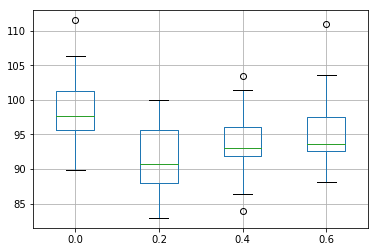

In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, n_batch, nb_epoch, n_neurons, dropout):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, recurrent_dropout=dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

# run a repeated experiment
def experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons, dropout):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(n_repeats):
        # fit the model
        train_trimmed = train_scaled[2:, :]
        lstm_model = fit_lstm(train_trimmed, n_batch, n_epochs, n_neurons, dropout)
        # forecast test dataset
        test_reshaped = test_scaled[:,0:-1]
        test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
        output = lstm_model.predict(test_reshaped, batch_size=n_batch)
        predictions = list()
        for i in range(len(output)):
            yhat = output[i,0]
            X = test_scaled[i, 0:-1]
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

# configure the experiment
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # configure the experiment
    n_lag = 1
    n_repeats = 30
    n_epochs = 1000
    n_batch = 4
    n_neurons = 3
    n_dropout = [0.0, 0.2, 0.4, 0.6]
    # run the experiment
    results = DataFrame()
    for dropout in n_dropout:
        results[str(dropout)] = experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons, dropout)
    # summarize results
    print(results.describe())
    # save boxplot
    results.boxplot()
    pyplot.savefig('experiment_dropout_recurrent.png')

# entry point
run()

### Diagnostics for Recurrent Dropout

Using TensorFlow backend.


1) TrainRMSE=60.288080, TestRMSE=95.044394
2) TrainRMSE=59.728336, TestRMSE=95.286210
3) TrainRMSE=60.558066, TestRMSE=97.468883
4) TrainRMSE=61.659307, TestRMSE=97.334660
5) TrainRMSE=60.274368, TestRMSE=90.446239
6) TrainRMSE=61.446545, TestRMSE=100.876093
7) TrainRMSE=59.280660, TestRMSE=96.291141
8) TrainRMSE=60.777422, TestRMSE=87.989860
9) TrainRMSE=61.992152, TestRMSE=89.299767
10) TrainRMSE=59.321732, TestRMSE=92.235643


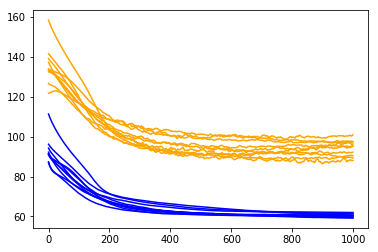

In [2]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
    # separate
    X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
    # reshape
    reshaped = X.reshape(len(X), 1, 1)
    # forecast dataset
    output = model.predict(reshaped, batch_size=batch_size)
    # invert data transforms on forecast
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        # invert scaling
        yhat = invert_scale(scaler, X[i], yhat)
        # invert differencing
        yhat = yhat + raw_data[i]
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
    # reset model state
    model.reset_states()
    return rmse

# fit an LSTM network to training data
def fit_lstm(train, test, raw, scaler, batch_size, nb_epoch, neurons, dropout):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # prepare model
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True, recurrent_dropout=dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit model
    train_rmse, test_rmse = list(), list()
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
        # evaluate model on train data
        raw_train = raw[-(len(train)+len(test)+1):-len(test)]
        train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
        # evaluate model on test data
        raw_test = raw[-(len(test)+1):]
        test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
    history = DataFrame()
    history['train'], history['test'] = train_rmse, test_rmse
    return history

# run diagnostic experiments
def run():
    # config
    n_lag = 1
    n_repeats = 10
    n_epochs = 1000
    n_batch = 4
    n_neurons = 3
    dropout = 0.4
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    # run diagnostic tests
    for i in range(n_repeats):
        history = fit_lstm(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons, dropout)
        pyplot.plot(history['train'], color='blue')
        pyplot.plot(history['test'], color='orange')
        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i+1, history['train'].iloc[-1], history['test'].iloc[-1]))
    pyplot.savefig('diagnostic_dropout_recurrent.png')

# entry point
run()

# Weight Regularization in LSTM Forecast Model
***
### Baseline LSTM with No Weight Regularization

### Baseline LSTM with No Weight Regularization

**Baseline LSTM Model**

Lag inputs: 1

Epochs: 1000

Units in LSTM hidden layer: 3

Batch Size: 4

Repeats: 3

1) Test RMSE: 97.897
2) Test RMSE: 93.577
3) Test RMSE: 88.248
4) Test RMSE: 92.251
5) Test RMSE: 89.576
6) Test RMSE: 90.822
7) Test RMSE: 95.707
8) Test RMSE: 99.957
9) Test RMSE: 105.966
10) Test RMSE: 100.172
11) Test RMSE: 96.219
12) Test RMSE: 90.934
13) Test RMSE: 100.977
14) Test RMSE: 91.873
15) Test RMSE: 99.841
16) Test RMSE: 100.789
17) Test RMSE: 98.340
18) Test RMSE: 91.733
19) Test RMSE: 99.277
20) Test RMSE: 95.799
21) Test RMSE: 95.082
22) Test RMSE: 102.268
23) Test RMSE: 103.511
24) Test RMSE: 103.316
25) Test RMSE: 95.229
26) Test RMSE: 99.814
27) Test RMSE: 100.579
28) Test RMSE: 94.268
29) Test RMSE: 99.418
30) Test RMSE: 97.141
          results
count   30.000000
mean    97.019311
std      4.528990
min     88.247534
25%     93.749493
50%     97.518826
75%    100.117961
max    105.965906


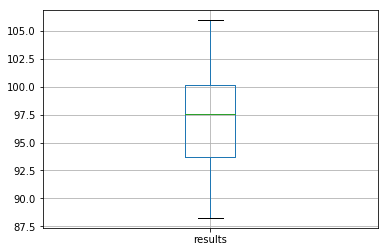

In [3]:
# Baseline model

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.regularizers import L1L2
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, n_batch, nb_epoch, n_neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

# run a repeated experiment
def experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(n_repeats):
        # fit the model
        train_trimmed = train_scaled[2:, :]
        lstm_model = fit_lstm(train_trimmed, n_batch, n_epochs, n_neurons)
        # forecast test dataset
        test_reshaped = test_scaled[:,0:-1]
        test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
        output = lstm_model.predict(test_reshaped, batch_size=n_batch)
        predictions = list()
        for i in range(len(output)):
            yhat = output[i,0]
            X = test_scaled[i, 0:-1]
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

# configure the experiment
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # configure the experiment
    n_lag = 1
    n_repeats = 30
    n_epochs = 1000
    n_batch = 4
    n_neurons = 3
    # run the experiment
    results = DataFrame()
    results['results'] = experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons)
    # summarize results
    print(results.describe())
    # save boxplot
    results.boxplot()
    pyplot.savefig('experiment_baseline.png')

# entry point
run()

### LSTM with Bias Regularization

L1L2(0.0, 0.0) [e.g. baseline]

L1L2(0.01, 0.0) [e.g. L1]

L1L2(0.0, 0.01) [e.g. L2]

L1L2(0.01, 0.01) [e.g. L1L2 or elasticnet]

Using TensorFlow backend.


1) Test RMSE: 102.777
2) Test RMSE: 100.660
3) Test RMSE: 96.467
4) Test RMSE: 91.780
5) Test RMSE: 106.456
6) Test RMSE: 94.140
7) Test RMSE: 103.213
8) Test RMSE: 103.062
9) Test RMSE: 94.612
10) Test RMSE: 101.496
11) Test RMSE: 108.645
12) Test RMSE: 89.820
13) Test RMSE: 93.387
14) Test RMSE: 93.138
15) Test RMSE: 100.668
16) Test RMSE: 92.265
17) Test RMSE: 98.729
18) Test RMSE: 98.922
19) Test RMSE: 96.227
20) Test RMSE: 89.787
21) Test RMSE: 107.529
22) Test RMSE: 96.423
23) Test RMSE: 96.853
24) Test RMSE: 91.736
25) Test RMSE: 94.962
26) Test RMSE: 100.271
27) Test RMSE: 98.060
28) Test RMSE: 91.837
29) Test RMSE: 93.854
30) Test RMSE: 107.273
1) Test RMSE: 112.015
2) Test RMSE: 103.522
3) Test RMSE: 104.176
4) Test RMSE: 105.388
5) Test RMSE: 99.567
6) Test RMSE: 105.438
7) Test RMSE: 97.677
8) Test RMSE: 104.732
9) Test RMSE: 105.768
10) Test RMSE: 101.012
11) Test RMSE: 93.421
12) Test RMSE: 103.079
13) Test RMSE: 95.429
14) Test RMSE: 104.277
15) Test RMSE: 94.452
16) Tes

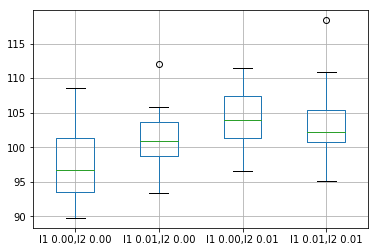

In [3]:
# Bias regularization

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.regularizers import L1L2
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

def fit_lstm(train, n_batch, nb_epoch, n_neurons, reg):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, bias_regularizer=reg))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

# run a repeated experiment
def experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons, reg):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(n_repeats):
        # fit the model
        train_trimmed = train_scaled[2:, :]
        lstm_model = fit_lstm(train_trimmed, n_batch, n_epochs, n_neurons, reg)
        # forecast test dataset
        test_reshaped = test_scaled[:,0:-1]
        test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
        output = lstm_model.predict(test_reshaped, batch_size=n_batch)
        predictions = list()
        for i in range(len(output)):
            yhat = output[i,0]
            X = test_scaled[i, 0:-1]
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores



# configure the experiment
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # configure the experiment
    n_lag = 1
    n_repeats = 30
    n_epochs = 1000
    n_batch = 4
    n_neurons = 3
    regularizers = [L1L2(l1=0.0, l2=0.0), L1L2(l1=0.01, l2=0.0), L1L2(l1=0.0, l2=0.01), L1L2(l1=0.01, l2=0.01)]
    # run the experiment
    results = DataFrame()
    for reg in regularizers:
        name = ('l1 %.2f,l2 %.2f' % (reg.l1, reg.l2))
        results[name] = experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons, reg)
    # summarize results
    print(results.describe())
    # save boxplot
    results.boxplot()
    pyplot.savefig('experiment_reg_bias.png')
    
# entry point
run()

### LSTM with Input Weight Regularization

L1L2(0.0, 0.0) [e.g. baseline]

L1L2(0.01, 0.0) [e.g. L1]

L1L2(0.0, 0.01) [e.g. L2]

L1L2(0.01, 0.01) [e.g. L1L2 or elasticnet]

1) Test RMSE: 101.371
2) Test RMSE: 100.994
3) Test RMSE: 98.716
4) Test RMSE: 98.953
5) Test RMSE: 96.569
6) Test RMSE: 101.550
7) Test RMSE: 92.127
8) Test RMSE: 96.960
9) Test RMSE: 101.623
10) Test RMSE: 95.843
11) Test RMSE: 105.829
12) Test RMSE: 92.828
13) Test RMSE: 99.643
14) Test RMSE: 98.263
15) Test RMSE: 93.901
16) Test RMSE: 92.899
17) Test RMSE: 102.790
18) Test RMSE: 95.993
19) Test RMSE: 93.719
20) Test RMSE: 92.674
21) Test RMSE: 93.332
22) Test RMSE: 93.376
23) Test RMSE: 105.526
24) Test RMSE: 105.957
25) Test RMSE: 94.418
26) Test RMSE: 95.873
27) Test RMSE: 98.271
28) Test RMSE: 103.585
29) Test RMSE: 97.860
30) Test RMSE: 99.616
1) Test RMSE: 121.421
2) Test RMSE: 104.333
3) Test RMSE: 117.664
4) Test RMSE: 113.855
5) Test RMSE: 113.360
6) Test RMSE: 108.642
7) Test RMSE: 109.512
8) Test RMSE: 102.048
9) Test RMSE: 106.976
10) Test RMSE: 124.006
11) Test RMSE: 115.376
12) Test RMSE: 112.408
13) Test RMSE: 111.389
14) Test RMSE: 114.766
15) Test RMSE: 108.002
16) 

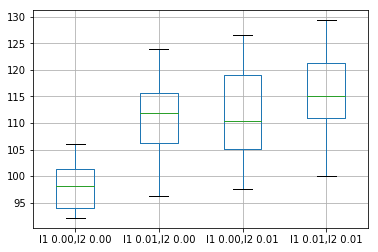

In [5]:
# Input regularization

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.regularizers import L1L2
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, n_batch, nb_epoch, n_neurons, reg):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, kernel_regularizer=reg))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

# run a repeated experiment
def experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons, reg):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(n_repeats):
        # fit the model
        train_trimmed = train_scaled[2:, :]
        lstm_model = fit_lstm(train_trimmed, n_batch, n_epochs, n_neurons, reg)
        # forecast test dataset
        test_reshaped = test_scaled[:,0:-1]
        test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
        output = lstm_model.predict(test_reshaped, batch_size=n_batch)
        predictions = list()
        for i in range(len(output)):
            yhat = output[i,0]
            X = test_scaled[i, 0:-1]
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

# configure the experiment
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # configure the experiment
    n_lag = 1
    n_repeats = 30
    n_epochs = 1000
    n_batch = 4
    n_neurons = 3
    regularizers = [L1L2(l1=0.0, l2=0.0), L1L2(l1=0.01, l2=0.0), L1L2(l1=0.0, l2=0.01), L1L2(l1=0.01, l2=0.01)]
    # run the experiment
    results = DataFrame()
    for reg in regularizers:
        name = ('l1 %.2f,l2 %.2f' % (reg.l1, reg.l2))
        results[name] = experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons, reg)
    # summarize results
    print(results.describe())
    # save boxplot
    results.boxplot()
    pyplot.savefig('experiment_reg_input.png')

# entry point
run()

### LSTM with Recurrent Weight Regularization

L1L2(0.0, 0.0) [e.g. baseline]

L1L2(0.01, 0.0) [e.g. L1]

L1L2(0.0, 0.01) [e.g. L2]

L1L2(0.01, 0.01) [e.g. L1L2 or elasticnet]

1) Test RMSE: 91.312
2) Test RMSE: 99.989
3) Test RMSE: 91.694
4) Test RMSE: 102.778
5) Test RMSE: 101.081
6) Test RMSE: 89.284
7) Test RMSE: 96.992
8) Test RMSE: 102.812
9) Test RMSE: 100.849
10) Test RMSE: 91.101
11) Test RMSE: 91.862
12) Test RMSE: 91.966
13) Test RMSE: 96.250
14) Test RMSE: 109.115
15) Test RMSE: 104.774
16) Test RMSE: 101.588
17) Test RMSE: 102.171
18) Test RMSE: 104.775
19) Test RMSE: 88.574
20) Test RMSE: 90.182
21) Test RMSE: 95.597
22) Test RMSE: 106.569
23) Test RMSE: 99.671
24) Test RMSE: 94.146
25) Test RMSE: 90.801
26) Test RMSE: 90.524
27) Test RMSE: 93.107
28) Test RMSE: 94.080
29) Test RMSE: 96.169
30) Test RMSE: 101.314
1) Test RMSE: 96.740
2) Test RMSE: 99.665
3) Test RMSE: 93.515
4) Test RMSE: 103.204
5) Test RMSE: 96.122
6) Test RMSE: 94.671
7) Test RMSE: 97.196
8) Test RMSE: 96.650
9) Test RMSE: 93.777
10) Test RMSE: 90.639
11) Test RMSE: 92.404
12) Test RMSE: 99.224
13) Test RMSE: 106.716
14) Test RMSE: 96.816
15) Test RMSE: 95.512
16) Test RMSE: 

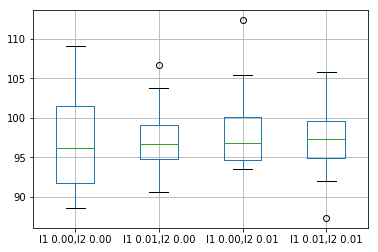

In [7]:
# Recurrent weight regularization

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.regularizers import L1L2
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, n_batch, nb_epoch, n_neurons, reg):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, recurrent_regularizer=reg))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

# run a repeated experiment
def experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons, reg):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(n_repeats):
        # fit the model
        train_trimmed = train_scaled[2:, :]
        lstm_model = fit_lstm(train_trimmed, n_batch, n_epochs, n_neurons, reg)
        # forecast test dataset
        test_reshaped = test_scaled[:,0:-1]
        test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
        output = lstm_model.predict(test_reshaped, batch_size=n_batch)
        predictions = list()
        for i in range(len(output)):
            yhat = output[i,0]
            X = test_scaled[i, 0:-1]
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

# configure the experiment
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # configure the experiment
    n_lag = 1
    n_repeats = 30
    n_epochs = 1000
    n_batch = 4
    n_neurons = 3
    regularizers = [L1L2(l1=0.0, l2=0.0), L1L2(l1=0.01, l2=0.0), L1L2(l1=0.0, l2=0.01), L1L2(l1=0.01, l2=0.01)]
    # run the experiment
    results = DataFrame()
    for reg in regularizers:
        name = ('l1 %.2f,l2 %.2f' % (reg.l1, reg.l2))
        results[name] = experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons, reg)
    # summarize results
    print(results.describe())
    # save boxplot
    results.boxplot()
    pyplot.savefig('experiment_reg_recurrent.png')

# entry point
run()

# _Multi-Step_ LSTM Forecasting
***
### Persistence LSTM _Multi-Step_ Forecast of Shampoo Sales

t+1 RMSE: 144.535304
t+2 RMSE: 86.479905
t+3 RMSE: 121.149168


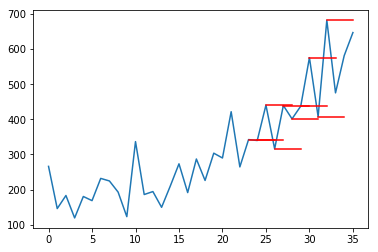

In [8]:
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    raw_values = raw_values.reshape(len(raw_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(raw_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return train, test

# make a persistence forecast
def persistence(last_ob, n_seq):
    return [last_ob for i in range(n_seq)]

# evaluate the persistence model
def make_forecasts(train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = persistence(X[-1], n_seq)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = test[:,(n_lag+i)]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    pyplot.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        pyplot.plot(xaxis, yaxis, color='red')
    # show the plot
    pyplot.show()

# load dataset
datafile = '~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv'
series = read_csv(datafile, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# configure
n_lag = 1
n_seq = 3
n_test = 10
# prepare data
train, test = prepare_data(series, n_test, n_lag, n_seq)
# make forecasts
forecasts = make_forecasts(train, test, n_lag, n_seq)
# evaluate forecasts
evaluate_forecasts(test, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)

**RMSE for PERSISTENCE Forecast**

t+1 RMSE: 144.535304

t+2 RMSE: 86.479905

t+3 RMSE: 121.149168
***
### Multi-Step LSTM Network Forecast of Shampoo Sales

t+1 RMSE: 186.359264
t+2 RMSE: 108.126904
t+3 RMSE: 177.628256


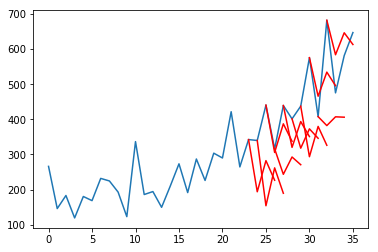

In [9]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    # transform data to be stationary
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

# invert differenced forecast
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    pyplot.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        pyplot.plot(xaxis, yaxis, color='red')
    # show the plot
    pyplot.show()

# load dataset
datafile = '~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv'
series = read_csv(datafile, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# configure
n_lag = 1
n_seq = 3
n_test = 10
n_epochs = 1500
n_batch = 1
n_neurons = 1
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)

**Full multi-step LSTM improves RSME over the Persistence forecast.**

t+1 RMSE: 96.559530

t+2 RMSE: 79.352093

t+3 RMSE: 109.033138
***
**LSTM extensions to improve forecasting results.**

 1. Update LSTM as new data becomes available: A 10s of training epochs should be sufficient to retrain with a new observation
 2. Tune the LSTM: Grid search some of the LSTM parameters used in the tutorial, such as:
  a. number of epochs
  b. number of neurons
  c. number of layers 
 3. Seq2Seq: Use the encoder-decoder paradigm for LSTMs to forecast each sequence to see if this offers any benefit.
 4. Change Time Horizons: 
  a. Experiment with forecasting different time horizons
  b. Experiment with different lead times

6. Repeats vs Test RMSE
 q. We can start to look at how the summary statistics for the experiment change as the number of repeats is increased from 1 to 100.
 r. We can accumulate the test RMSE scores and calculate descriptive statistics. For example, the score from one repeat, the scores from the first and second repeats, the scores from the first 3 repeats, and so on to 100 repeats.
 s. We can review how the central tendency changes as the number of repeats is increased as a line plot. We’ll look at both the mean and median.
 t. Generally, we would expect that as the number of repeats of the experiment is increased, the distribution would increasingly better match the underlying distribution, including the central tendency, such as the mean.

# Stability of Online Learning in Stateful LSTMs for Time Series Forecasting
***
To close this post, we will examine the stability of LSTMs for online learning (i.e. batch size = 1). Online or _real-time_ learning is where a trained model is updated with every response. This experiment is designed to determine the appropriateness of online learning in LSTMs used for time series forecasting. 

1. Setup Experiment
 a. Data Split: We will split the Shampoo Sales dataset into two parts: a training and a test set. The first two years of data will be taken for the training dataset and the remaining one year of data will be used for the test set.
 b. Models will be developed using the training dataset and will make predictions on the test dataset.
 c. The persistence forecast (naive forecast) on the test dataset achieves an error of 136.761 monthly shampoo sales. This provides a lower acceptable bound of performance on the test set.

2. Model Evaluation
 d. A rolling-forecast scenario will be used, also called walk-forward model validation. Each time step of the test dataset will be walked one at a time. A model will be used to make a forecast for the time step, then the actual expected value from the test set will be taken and made available to the model for the forecast on the next time step.
 e. All forecasts on the test dataset will be collected and an error score calculated to summarize the skill of the model. The root mean squared error (RMSE) will be used as it punishes large errors and results in a score that is in the same units as the forecast data, namely monthly shampoo sales.

3. Data Preparation & Transformations
 f. Transform the time series data so that it is stationary. Specifically a lag=1 differencing to remove the increasing trend in the data.
 g. Transform the time series into a supervised learning problem. Specifically the organization of data into input and output patterns where the observation at the previous time step is used as an input to forecast the observation at the current time step
 h. Transform the observations to have a specific scale. Specifically, to rescale the data to values between -1 and 1 to meet the default hyperbolic tangent activation function of the LSTM model.
 i. These transforms are inverted on forecasts to return them into their original scale before calculating and error score.

4. LSTM Model
 j. We will use a base stateful LSTM model with 1 neuron fit for 1000 epochs.
 k. A batch size of 1 is required as we will be using walk-forward validation and making one-step forecasts for each of the final 12 months of test data.
 l.A batch size of 1 means that the model will be fit using online training (as opposed to batch training or mini-batch training). As a result, it is expected that the model fit will have some variance.
 m. Ideally, more training epochs would be used (such as 1500), but this was truncated to 1000 to keep run times reasonable.
 n. The model will be fit using the efficient ADAM optimization algorithm and the mean squared error loss function.

5. Experimental Runs
 o. Each experimental scenario will be run 100 times and the RMSE score on the test set will be recorded from the end each run.
 p. All test RMSE scores are written to file for later analysis.

In [2]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# run a repeated experiment
def experiment(repeats, series):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values[1:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the base model
        lstm_model = fit_lstm(train_scaled, 1, 1000, 1)
        # forecast test dataset
        predictions = list()
        for i in range(len(test_scaled)):
            # predict
            X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, 1, X)
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

# execute the experiment
def run():
    # load dataset
    series = read_csv('~/NOTEBOOKS-LSTM-timeseries/data/Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 100
    results = DataFrame()
    # run experiment
    results['results'] = experiment(repeats, series)
    # summarize results
    print(results.describe())
    # save results
    results.to_csv('experiment_stateful.csv', index=False)

 # entry point
run()

Using TensorFlow backend.


1) Test RMSE: 112.100
2) Test RMSE: 101.620
3) Test RMSE: 141.072
4) Test RMSE: 91.997
5) Test RMSE: 93.307
6) Test RMSE: 113.990
7) Test RMSE: 104.147
8) Test RMSE: 102.180
9) Test RMSE: 104.392
10) Test RMSE: 94.680
11) Test RMSE: 96.909
12) Test RMSE: 94.037
13) Test RMSE: 102.579
14) Test RMSE: 146.762
15) Test RMSE: 89.397
16) Test RMSE: 108.293
17) Test RMSE: 91.812
18) Test RMSE: 102.495
19) Test RMSE: 136.701
20) Test RMSE: 101.829
21) Test RMSE: 101.198
22) Test RMSE: 100.504
23) Test RMSE: 97.970
24) Test RMSE: 99.742
25) Test RMSE: 93.262
26) Test RMSE: 104.127
27) Test RMSE: 102.821
28) Test RMSE: 101.770
29) Test RMSE: 98.067
30) Test RMSE: 104.908
31) Test RMSE: 178.679
32) Test RMSE: 94.104
33) Test RMSE: 100.960
34) Test RMSE: 133.058
35) Test RMSE: 114.586
36) Test RMSE: 189.962
37) Test RMSE: 104.696
38) Test RMSE: 101.426
39) Test RMSE: 91.546
40) Test RMSE: 106.364
41) Test RMSE: 116.680
42) Test RMSE: 233.454
43) Test RMSE: 103.859
44) Test RMSE: 90.030
45) Test RM

### Descriptive Statistics on Experimental Results

          results
count  100.000000
mean   108.476011
std     25.675930
min     89.396935
25%     95.591574
50%    101.799630
75%    106.494940
max    233.454252


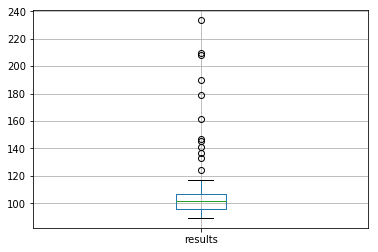

In [3]:
% matplotlib inline

from pandas import DataFrame, read_csv
from numpy import mean, std
from matplotlib import pyplot

# load results
results = read_csv('experiment_stateful.csv', header=0)
# descriptive stats
print(results.describe())
# box and whiskers plot
results.boxplot()
pyplot.show()

### Repeats vs Test RMSE

1 112.100447707 112.100447707
2 106.86008147 106.86008147
3 118.264013178 112.100447707
4 111.697353231 106.86008147
5 108.019260535 101.619715232
6 109.014329655 106.86008147
7 108.31905598 104.147413931
8 107.551676461 103.163716881
9 107.200616997 104.147413931
10 105.948572326 103.163716881
11 105.126812215 102.180019831
12 104.202622164 101.899867532
13 104.077738634 102.180019831
14 107.126633481 102.379578052
15 105.94465356 102.180019831
16 106.09143423 102.379578052
17 105.251448434 102.180019831
18 105.098327986 102.337650097
19 106.761651469 102.495280364
20 106.515034648 102.337650097
21 106.261834995 102.180019831
22 106.000117425 102.004667441
23 105.65097084 101.82931505
24 105.40477008 101.724515141
25 104.919056692 101.619715232
26 104.888593981 101.724515141
27 104.812016875 101.82931505
28 104.703371469 101.799630271
29 104.474524551 101.769945492
30 104.488977385 101.799630271
31 106.882201374 101.82931505
32 106.482886153 101.799630271
33 106.315511538 101.76994549

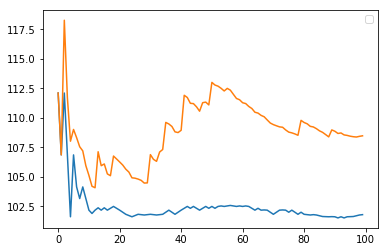

In [5]:
from pandas import DataFrame, read_csv
from numpy import mean, median
from matplotlib import pyplot
import numpy

# load results
results = read_csv('experiment_stateful.csv', header=0)
values = results.values
 
# collect cum stats
medians, means = list(), list()
for i in range(1, len(values)+1):
    data = values[0:i, 0]
    mean_rmse, median_rmse = mean(data), median(data)
    means.append(mean_rmse)
    medians.append(median_rmse)
    print(i, mean_rmse, median_rmse)
# line plot of cum values
line1 = pyplot.plot(medians) #, label='Median RMSE')
line2 = pyplot.plot(means) #, label='Mean RMSE')
pyplot.legend((line1, line2), ('Median RMSE', 'Mean RMSE'))
pyplot.show()

6. Repeats vs Test RMSE

 q. We can start to look at how the summary statistics for the experiment change as the number of repeats is increased from 1 to 100.
 
 r. We can accumulate the test RMSE scores and calculate descriptive statistics. For example, the score from one repeat, the scores from the first and second repeats, the scores from the first 3 repeats, and so on to 100 repeats.
 
 s. We can review how the central tendency changes as the number of repeats is increased as a line plot. We’ll look at both the mean and median.
 
 t. Generally, we would expect that as the number of repeats of the experiment is increased, the distribution would increasingly better match the underlying distribution, including the central tendency, such as the mean.

# Epilogue
***
Key points:

1. LSTMs must be tuned for optimal performance
2. Seeding and Resetting the state of the memory cell matters
3. Feature engineering can help improve performance
